In [3]:
%pip install tensorflow opencv-python mediapipe scikit-learn matplotlib pandas pyarrow wandb plotly tqdm

/usr/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  Obtaining dependency information for tqdm from https://files.pythonhosted.org/packages/2a/14/e75e52d521442e2fcc9f1df3c5e456aead034203d4797867980de558ab34/tqdm-4.66.2-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 10.4 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
import math
import pandas as pd
import numpy as np
#Load parquet data into dataset_parquet for training.
import tensorflow as tf
from tensorflow import keras
from keras.regularizers import l2
from glob import glob
from tqdm import tqdm
from collections import Counter
import random
import time
import wandb

In [5]:
class CONFIG:
    # root = os.path.join("/", "kaggle", "input", "asl-signs") 
    root = os.path.join(".")
    DATA_LIMIT = 100
    BATCH_SIZE = 8
    VIDEO_LENGTH = 60
    TRAIN_VAL_SPLIT = 0.9
    WANDB_RUN = "mediapipe-asl-dataset"


In [6]:
LIPS_IDXS0 = np.array([
        61, 185, 40, 39, 37, 0, 267, 269, 270, 409,
        291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
        78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
        95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
    ])

EYE_LEFT = np.array([33, 7, 246, 161, 160, 159, 158, 157, 173, 133, 155, 154, 153, 145, 144, 163, 471, 470, 469, 472])
EYE_RIGHT = np.array([362, 398, 384, 385, 386, 387, 388, 466, 263, 249, 390, 373, 374, 380, 381, 382, 476, 475, 474, 477])
# Landmark indices in original data
LEFT_HAND_IDXS0 = np.arange(468,489)
RIGHT_HAND_IDXS0 = np.arange(522,543)
LEFT_POSE_IDXS0 = np.array([502, 504, 506, 508, 510])
RIGHT_POSE_IDXS0 = np.array([503, 505, 507, 509, 511])

print("LIPS : ",len(LIPS_IDXS0))
print("EYE_LEFT : ",len(EYE_LEFT))
print("EYE_RIGHT : ",len(EYE_RIGHT))
print("LEFT_HAND : ",len(LEFT_HAND_IDXS0))
print("RIGHT_HAND : ",len(RIGHT_HAND_IDXS0))
print("LEFT_POSE : ",len(LEFT_POSE_IDXS0))
print("RIGHT_POSE : ",len(RIGHT_POSE_IDXS0))

all_selection = np.concatenate([LIPS_IDXS0, EYE_LEFT, EYE_RIGHT, LEFT_HAND_IDXS0, RIGHT_HAND_IDXS0, LEFT_POSE_IDXS0, RIGHT_POSE_IDXS0])
print(len(all_selection))

LIPS :  40
EYE_LEFT :  20
EYE_RIGHT :  20
LEFT_HAND :  21
RIGHT_HAND :  21
LEFT_POSE :  5
RIGHT_POSE :  5
132


In [7]:
#this code sorts out a parquet files and rearrange the order to pose,face, left-hand, right-hand
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import plotly.graph_objs as go
import plotly.io as pio

ids = None

order_global = {"pose" : 10000, "face" : 1000, "left_hand" : 100, "right_hand" : 10}

def visualize_keypoints(frames : np.ndarray, point_size : int):
    if len(frames.shape) == 1:
        frames = np.array([frames])
    
    for frame in frames:
        frame = frame.reshape(-1, 3)
        sizes = point_size * np.ones(frame.shape[0])

        fig = go.Figure(data=go.Scatter(x=frame[:,0], y=2.5 - frame[:,1], mode='markers',
                                        marker=dict(
                                            size=sizes
                                            )))

    # Customize the layout
    fig.update_layout(title='visualization of human keypoints',
                        xaxis_title='',
                        yaxis_title='',
                        width=1000,
                        height=1600)

    fig.update_xaxes(range=[-0.2, 1.4])  # Set x-axis range from 0 to 6
    fig.update_yaxes(range=[0, 2.5])  # Set y-axis range from 10 to 20

    # Show the plot
    fig.show()


def process_parquet(ds, idxes = None):
    ret = []
    frames_unique = sorted(np.unique(ds["frame"]))
    for i,frame in enumerate(frames_unique):
        frame_ds = ds[ds['frame'] == frame]
        
        order = []
        for el in frame_ds["row_id"]:
            _frame, part, keypoint = el.split("-")
            order.append(order_global[part] - int(keypoint))

        order = np.array(order)
        frame_ds.iloc[:, 1] = order
        frame_ds = frame_ds.sort_values(by="row_id", ascending=False)
    
        vals = np.array(frame_ds[["x", "y", "z"]])
        if idxes is not None:
            vals = vals[idxes]
    
        vals = vals.flatten()

        ret.append(vals)
        
    return np.array(ret)


def process_parquet2(ds, idxes = None):
    ret = []    
    frame_size = 543
    it = len(ds) // frame_size
    assert it == len(ds) / frame_size
    
    for i in range(it):
        vals = ds.iloc[ i * frame_size : (i + 1 ) * frame_size ]        
        
        if idxes is not None:          
            vals = ds.iloc[idxes]
                        
        ret.append(np.array(vals[["x","y", "z"]]).flatten())
        
    return np.array(np.array(ret))

In [8]:
f = process_parquet(pd.read_parquet("79631423.parquet"))
visualize_keypoints(f[0], point_size=10)

FileNotFoundError: [Errno 2] No such file or directory: '79631423.parquet'

In [ ]:
f2 = process_parquet2(pd.read_parquet("79631423.parquet"), idxes=all_selection)
visualize_keypoints(f2[0], point_size=10)

In [9]:
df = pd.read_parquet( os.path.join("..", "data","ASL-ds", "train_landmark_files", "16069", "695046.parquet"))

FileNotFoundError: [Errno 2] No such file or directory: '../data/ASL-ds/train_landmark_files/16069/695046.parquet'

In [11]:
from sklearn.model_selection import train_test_split

#custom class to load data from Parquet files for training ML models.
class ParquetDataset(keras.utils.Sequence):
    def __init__(self, dataset_folder, csv_file : str, batch_size=CONFIG.BATCH_SIZE, 
                 data_limit :int= CONFIG.DATA_LIMIT, check_if_file_exists = True, 
                 preprocessing_func=None, frame_length :int = CONFIG.VIDEO_LENGTH,
                 split : str = "train", train_val_split : float = CONFIG.TRAIN_VAL_SPLIT,
                 sort_by_counts : bool = True, **kwargs
                ):
        super().__init__(**kwargs)
        #taking keras sequence for .fit(), .evaluate(), .predict() methods
        #load csv - it has the path to parquet file, and another to store label
        self.csv_path = csv_file
        self.root_folder = dataset_folder
        self.batch_size = batch_size
        #optional pre-processing function to the parquet files.
        self.preprocessing_func = preprocessing_func
        
        self.csv_data = pd.read_csv(self.csv_path)
        
        self.all_files = []
        self.not_exists = []
        self.frame_length = frame_length

        
        for path, label in tqdm(list(zip(self.csv_data["path"], self.csv_data["sign"]))):
            prop_path = os.path.join(self.root_folder, path)
            
            if check_if_file_exists:
                if os.path.exists(prop_path):
                    self.all_files.append((prop_path, label))
                else:
                    self.not_exists.append(prop_path)
            else:
                self.all_files.append((prop_path, label))
                
                    
        self.all_files = np.array(self.all_files)
        self.unique_labels = np.unique(self.all_files[:, 1])
        self.label_2_id = { key : i for i, key in enumerate(self.unique_labels)}
    
        # sort the values by popularity
        if sort_by_counts:
            cnt = Counter(self.all_files[:, 1])
            vals = []
            
            for i,row in enumerate(self.all_files):
                vals.append((int(1e6 * cnt[row[1]] + self.label_2_id [row[1]]),i))
            
            vals = np.array(sorted(vals)[::-1])
            self.all_files = self.all_files[vals[:,1]]

        
        if data_limit < 0:
            train_ds, val_ds = train_test_split(self.all_files, train_size=train_val_split, random_state=42)
        else:
            train_ds, val_ds = train_test_split(self.all_files[:data_limit], train_size=train_val_split, random_state=42)
            self.unique_labels = np.unique(self.all_files[:data_limit, 1])
            self.label_2_id = { key : i for i, key in enumerate(self.unique_labels)}
            
        if split.lower() == "train":
            self.dataset = train_ds
            
        elif split.lower() == "val":
            self.dataset = val_ds 
            
        else:
            raise Exception("please specify split to be either train or val")
            
        np.random.shuffle(self.dataset)
                   

    def __len__(self):
        # Assuming each Parquet file should be one batch; adjust if necessary
        return math.ceil(len(self.dataset) / self.batch_size)
    
    def get_single(self, idx):
        # Load one file per batch
        #take the idx value, 1st label, 
        path, label = self.dataset[idx]
        
        df = pd.read_parquet( path)
        
        # Apply preprocessing if specified
        if self.preprocessing_func:
            df = self.preprocessing_func(df, self.frame_length)
        
        one_hot_encoded_label = np.zeros(len(self.unique_labels))
        one_hot_encoded_label[self.label_2_id[label]] = 1  
        
        return df, one_hot_encoded_label

    def __getitem__(self, idx):
        X, Y = [], []
        
        low = idx * self.batch_size
        high = min(low + self.batch_size, len(self.dataset))
        
        for i in range(low, high):
            x, y = self.get_single(i)
            X.append(x)
            Y.append(y)
        
        return np.array(X), np.array(Y)
                
        
    def on_epoch_end(self):
        # Shuffle files for the next epoch
        np.random.shuffle(self.dataset)

def my_preprocessing_func(df, frame_length):
    
    # Define your preprocessing steps here
    # Example: normalize numerical features
    frames_mediapipe = process_parquet2(df, all_selection)
    
    current_length, num_features = frames_mediapipe.shape

    if current_length >= frame_length:
            # TODO: a better than uniform value ? Could place gaussian in the middle
            random_start = random.randint(0, current_length - frame_length)
            return np.nan_to_num(frames_mediapipe[random_start : (random_start + frame_length)])
        
    # padd the video to contain zeros 
    return np.concatenate([np.nan_to_num(frames_mediapipe), np.zeros((frame_length - current_length, num_features))], axis=0)
    
# Usage example
parquet_folder_path = CONFIG.root
train_dataset_parquet = ParquetDataset(parquet_folder_path, csv_file = os.path.join(CONFIG.root, "train.csv"), 
                                 batch_size=CONFIG.BATCH_SIZE, data_limit=1000,
                                 preprocessing_func=my_preprocessing_func,
                                check_if_file_exists = True,
                                split="train")

val_dataset_parquet = ParquetDataset(parquet_folder_path, csv_file = os.path.join(CONFIG.root, "train.csv"), 
                                 batch_size=CONFIG.BATCH_SIZE, data_limit=1000,
                                 preprocessing_func=my_preprocessing_func,
                                 check_if_file_exists= True,
                                 split="val")

print(f"cardinality of train : {len(train_dataset_parquet)}, cardinality of validation : {len(val_dataset_parquet)}")

100%|██████████| 94477/94477 [00:00<00:00, 315050.58it/s]


cardinality of train : 113, cardinality of validation : 13


In [19]:
NUM_FEATURES = train_dataset_parquet[0][0].shape[-1]

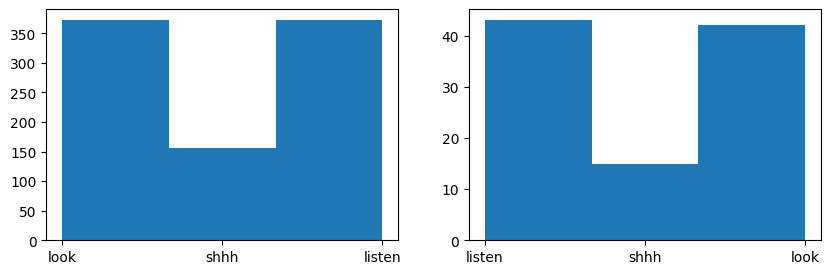

In [12]:
import matplotlib.pyplot as plt 


plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.hist(train_dataset_parquet.dataset[:, 1], bins=len(train_dataset_parquet.unique_labels))

plt.subplot(1, 2, 2)
plt.hist(val_dataset_parquet.dataset[:, 1], bins=len(val_dataset_parquet.unique_labels))

plt.show()

In [19]:
start = time.time()
isnans =False

f = True
labels_batches = []
for el in tqdm(train_dataset_parquet):
    if f:
        print(el[0].shape, el[1].shape)
        f = False
    labels_batches.append(el[1])
        
    isnans |= np.any(np.isnan(el[0]))
    if isnans:
        print("FOUND NAN!")
        break


print(f"Iterating through dataset took : {round( time.time() - start , 4)}s")

  1%|          | 1/113 [00:00<00:21,  5.19it/s]

(8, 60, 396) (8, 3)


100%|██████████| 113/113 [00:20<00:00,  5.40it/s]

Iterating through dataset took : 20.9304s


# Train experiment

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, LeakyReLU
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import backend as K
from wandb.keras import WandbMetricsLogger
from keras.callbacks import Callback
import tensorflow as tf
import wandb


class CosineAnnealingLearningRateScheduler(Callback):
    def __init__(self, max_lr, min_lr, T_max):
        super(CosineAnnealingLearningRateScheduler, self).__init__()
        self.max_lr = max_lr  # Maximum learning rate (i.e., start learning rate)
        self.min_lr = min_lr  # Minimum learning rate
        self.T_max = T_max    # Specifies the number of epochs per cycle
        self.t = 0            # Current epoch

    def on_epoch_begin(self, epoch, logs=None):
        self.t += 1
        cos = np.cos(np.pi * (self.t % self.T_max) / self.T_max)
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + cos)

        keras.backend.set_value(self.model.optimizer.lr, lr)

def keras_train(model, filepath : str, max_lr = 1e-4, min_lr = 5e-5, T_max=50, epochs=100, run_name="",
                mediapipe_features = "all", USE_WANDB=True): 
    
    
    checkpoint = keras.callbacks.ModelCheckpoint(filepath,
                                                 monitor="val_categorical_accuracy",
                                                 verbose=0,
                                                 save_best_only=True,
                                                 mode="max",
                                                 save_freq="epoch")
    
    cosine_annealer = CosineAnnealingLearningRateScheduler(max_lr=max_lr,
                                                           min_lr=min_lr,
                                                           T_max=T_max)
    
    #Adam Optimizer - fixed learning rate.
    adam_optimizer = tf.keras.optimizers.Adam(learning_rate=max_lr, clipnorm=1.)

    model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    
    callbacks  = [checkpoint, cosine_annealer]
    
    if USE_WANDB:
        wandb.init(project=CONFIG.WANDB_RUN,
                        name=run_name,
                        notes="Model summary : \n" + str(model),
                        config={"max_lr" : max_lr, 
                                "min_lr" : 5e-5, 
                                "scheduler" : "cosineAnnealer", 
                                "epochs" : epochs, 
                                "T_max" : T_max, 
                                "train_size" : len(train_dataset_parquet.dataset),
                                "val_size" : len(val_dataset_parquet.dataset),
                                "unique_classes" : len(train_dataset_parquet.unique_labels), 
                                "video_length" : CONFIG.VIDEO_LENGTH,
                                "features" : mediapipe_features
                                })
        callbacks.append(WandbMetricsLogger())


    history = model.fit(train_dataset_parquet, epochs=epochs, validation_data = val_dataset_parquet, 
                        batch_size = 8, callbacks=callbacks)
    
    if USE_WANDB:      
        wandb.finish()
    
    return history

# Train simple LSTM

In [23]:
model = Sequential()
#x,y,z -> y,z as the input shape
model.add(LSTM(128, return_sequences=False, input_shape=(CONFIG.VIDEO_LENGTH, 396),
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", "LSTM1.tf"),
            run_name="LSTM128-Dense128-Dense256-LipsEyesHandsPose",
           mediapipe_features="LipsEyesHandsPose")

Epoch 1/100
113/113 [==============================] - ETA: 0s - loss: 1.1253 - categorical_accuracy: 0.4100INFO:tensorflow:Assets written to: models/LSTM1.tf/assets


INFO:tensorflow:Assets written to: models/LSTM1.tf/assets


113/113 [==============================] - 33s 263ms/step - loss: 1.1253 - categorical_accuracy: 0.4100 - val_loss: 1.0921 - val_categorical_accuracy: 0.4000
Epoch 2/100
113/113 [==============================] - ETA: 0s - loss: 1.0779 - categorical_accuracy: 0.4244INFO:tensorflow:Assets written to: models/LSTM1.tf/assets


INFO:tensorflow:Assets written to: models/LSTM1.tf/assets


113/113 [==============================] - 29s 258ms/step - loss: 1.0779 - categorical_accuracy: 0.4244 - val_loss: 1.0197 - val_categorical_accuracy: 0.4700
Epoch 3/100
113/113 [==============================] - 23s 203ms/step - loss: 0.9808 - categorical_accuracy: 0.4444 - val_loss: 0.8970 - val_categorical_accuracy: 0.4700
Epoch 4/100
113/113 [==============================] - ETA: 0s - loss: 0.9248 - categorical_accuracy: 0.5056INFO:tensorflow:Assets written to: models/LSTM1.tf/assets


INFO:tensorflow:Assets written to: models/LSTM1.tf/assets


113/113 [==============================] - 30s 263ms/step - loss: 0.9248 - categorical_accuracy: 0.5056 - val_loss: 0.8610 - val_categorical_accuracy: 0.5500
Epoch 5/100
113/113 [==============================] - ETA: 0s - loss: 0.9150 - categorical_accuracy: 0.5144INFO:tensorflow:Assets written to: models/LSTM1.tf/assets


INFO:tensorflow:Assets written to: models/LSTM1.tf/assets


113/113 [==============================] - 30s 265ms/step - loss: 0.9150 - categorical_accuracy: 0.5144 - val_loss: 0.8333 - val_categorical_accuracy: 0.5600
Epoch 6/100
113/113 [==============================] - ETA: 0s - loss: 0.8939 - categorical_accuracy: 0.5267INFO:tensorflow:Assets written to: models/LSTM1.tf/assets


INFO:tensorflow:Assets written to: models/LSTM1.tf/assets


113/113 [==============================] - 29s 260ms/step - loss: 0.8939 - categorical_accuracy: 0.5267 - val_loss: 0.8182 - val_categorical_accuracy: 0.6200
Epoch 7/100
113/113 [==============================] - 23s 199ms/step - loss: 0.8660 - categorical_accuracy: 0.5378 - val_loss: 0.7977 - val_categorical_accuracy: 0.5500
Epoch 8/100
113/113 [==============================] - 23s 204ms/step - loss: 0.8511 - categorical_accuracy: 0.5489 - val_loss: 0.7955 - val_categorical_accuracy: 0.5900
Epoch 9/100
113/113 [==============================] - 23s 201ms/step - loss: 0.8241 - categorical_accuracy: 0.5767 - val_loss: 0.7956 - val_categorical_accuracy: 0.6200
Epoch 10/100
113/113 [==============================] - ETA: 0s - loss: 0.8189 - categorical_accuracy: 0.5844INFO:tensorflow:Assets written to: models/LSTM1.tf/assets


INFO:tensorflow:Assets written to: models/LSTM1.tf/assets


113/113 [==============================] - 30s 263ms/step - loss: 0.8189 - categorical_accuracy: 0.5844 - val_loss: 0.7627 - val_categorical_accuracy: 0.6400
Epoch 11/100
113/113 [==============================] - ETA: 0s - loss: 0.7835 - categorical_accuracy: 0.6244INFO:tensorflow:Assets written to: models/LSTM1.tf/assets


INFO:tensorflow:Assets written to: models/LSTM1.tf/assets


113/113 [==============================] - 29s 257ms/step - loss: 0.7835 - categorical_accuracy: 0.6244 - val_loss: 0.7299 - val_categorical_accuracy: 0.7000
Epoch 12/100
113/113 [==============================] - 22s 197ms/step - loss: 0.7454 - categorical_accuracy: 0.6822 - val_loss: 0.7676 - val_categorical_accuracy: 0.6400
Epoch 13/100
113/113 [==============================] - 23s 202ms/step - loss: 0.7114 - categorical_accuracy: 0.6978 - val_loss: 0.7432 - val_categorical_accuracy: 0.6800
Epoch 14/100
113/113 [==============================] - ETA: 0s - loss: 0.7309 - categorical_accuracy: 0.6856INFO:tensorflow:Assets written to: models/LSTM1.tf/assets


INFO:tensorflow:Assets written to: models/LSTM1.tf/assets


113/113 [==============================] - 30s 263ms/step - loss: 0.7309 - categorical_accuracy: 0.6856 - val_loss: 0.7056 - val_categorical_accuracy: 0.7100
Epoch 15/100
113/113 [==============================] - ETA: 0s - loss: 0.6905 - categorical_accuracy: 0.7189INFO:tensorflow:Assets written to: models/LSTM1.tf/assets


INFO:tensorflow:Assets written to: models/LSTM1.tf/assets


113/113 [==============================] - 29s 258ms/step - loss: 0.6905 - categorical_accuracy: 0.7189 - val_loss: 0.6531 - val_categorical_accuracy: 0.7300
Epoch 16/100
113/113 [==============================] - ETA: 0s - loss: 0.6553 - categorical_accuracy: 0.7256INFO:tensorflow:Assets written to: models/LSTM1.tf/assets


INFO:tensorflow:Assets written to: models/LSTM1.tf/assets


113/113 [==============================] - 31s 277ms/step - loss: 0.6553 - categorical_accuracy: 0.7256 - val_loss: 0.6715 - val_categorical_accuracy: 0.7400
Epoch 17/100
113/113 [==============================] - 23s 202ms/step - loss: 0.6307 - categorical_accuracy: 0.7500 - val_loss: 0.6876 - val_categorical_accuracy: 0.6900
Epoch 18/100
113/113 [==============================] - ETA: 0s - loss: 0.6334 - categorical_accuracy: 0.7467INFO:tensorflow:Assets written to: models/LSTM1.tf/assets


INFO:tensorflow:Assets written to: models/LSTM1.tf/assets


113/113 [==============================] - 29s 255ms/step - loss: 0.6334 - categorical_accuracy: 0.7467 - val_loss: 0.6008 - val_categorical_accuracy: 0.8000
Epoch 19/100
113/113 [==============================] - ETA: 0s - loss: 0.6744 - categorical_accuracy: 0.7278INFO:tensorflow:Assets written to: models/LSTM1.tf/assets


INFO:tensorflow:Assets written to: models/LSTM1.tf/assets


113/113 [==============================] - 30s 262ms/step - loss: 0.6744 - categorical_accuracy: 0.7278 - val_loss: 0.5728 - val_categorical_accuracy: 0.8200
Epoch 20/100
113/113 [==============================] - 23s 202ms/step - loss: 0.6020 - categorical_accuracy: 0.7689 - val_loss: 0.5708 - val_categorical_accuracy: 0.7600
Epoch 21/100
113/113 [==============================] - 23s 202ms/step - loss: 0.6196 - categorical_accuracy: 0.7600 - val_loss: 0.5965 - val_categorical_accuracy: 0.7700
Epoch 22/100
113/113 [==============================] - 23s 203ms/step - loss: 0.5918 - categorical_accuracy: 0.7800 - val_loss: 0.6273 - val_categorical_accuracy: 0.7700
Epoch 23/100
113/113 [==============================] - 23s 201ms/step - loss: 0.6016 - categorical_accuracy: 0.7733 - val_loss: 0.6371 - val_categorical_accuracy: 0.7800
Epoch 24/100
113/113 [==============================] - 23s 203ms/step - loss: 0.5681 - categorical_accuracy: 0.7922 - val_loss: 0.5793 - val_categorical_accu

INFO:tensorflow:Assets written to: models/LSTM1.tf/assets


113/113 [==============================] - 30s 268ms/step - loss: 0.5061 - categorical_accuracy: 0.8111 - val_loss: 0.5410 - val_categorical_accuracy: 0.8400
Epoch 51/100
113/113 [==============================] - 23s 208ms/step - loss: 0.5446 - categorical_accuracy: 0.8022 - val_loss: 0.6589 - val_categorical_accuracy: 0.7500
Epoch 52/100
113/113 [==============================] - 23s 204ms/step - loss: 0.6166 - categorical_accuracy: 0.7833 - val_loss: 0.5433 - val_categorical_accuracy: 0.8000
Epoch 53/100
113/113 [==============================] - 23s 205ms/step - loss: 0.5318 - categorical_accuracy: 0.8122 - val_loss: 0.5758 - val_categorical_accuracy: 0.8000
Epoch 54/100
113/113 [==============================] - 23s 204ms/step - loss: 0.5203 - categorical_accuracy: 0.8211 - val_loss: 0.7170 - val_categorical_accuracy: 0.7600
Epoch 55/100
113/113 [==============================] - 24s 209ms/step - loss: 0.5346 - categorical_accuracy: 0.8178 - val_loss: 0.5050 - val_categorical_accu

INFO:tensorflow:Assets written to: models/LSTM1.tf/assets


113/113 [==============================] - 29s 260ms/step - loss: 0.4993 - categorical_accuracy: 0.8389 - val_loss: 0.5406 - val_categorical_accuracy: 0.8500
Epoch 70/100
113/113 [==============================] - 23s 204ms/step - loss: 0.4850 - categorical_accuracy: 0.8322 - val_loss: 0.5145 - val_categorical_accuracy: 0.8300
Epoch 71/100
113/113 [==============================] - 23s 203ms/step - loss: 0.4589 - categorical_accuracy: 0.8478 - val_loss: 0.5249 - val_categorical_accuracy: 0.8300
Epoch 72/100
113/113 [==============================] - 23s 207ms/step - loss: 0.4838 - categorical_accuracy: 0.8289 - val_loss: 0.4846 - val_categorical_accuracy: 0.8500
Epoch 73/100
113/113 [==============================] - 23s 207ms/step - loss: 0.4735 - categorical_accuracy: 0.8411 - val_loss: 0.6151 - val_categorical_accuracy: 0.7600
Epoch 74/100
113/113 [==============================] - 23s 206ms/step - loss: 0.4451 - categorical_accuracy: 0.8533 - val_loss: 0.6607 - val_categorical_accu

INFO:tensorflow:Assets written to: models/LSTM1.tf/assets


113/113 [==============================] - 30s 264ms/step - loss: 0.4259 - categorical_accuracy: 0.8611 - val_loss: 0.4284 - val_categorical_accuracy: 0.8700
Epoch 78/100
113/113 [==============================] - 23s 206ms/step - loss: 0.4545 - categorical_accuracy: 0.8422 - val_loss: 0.4475 - val_categorical_accuracy: 0.8300
Epoch 79/100
113/113 [==============================] - 23s 204ms/step - loss: 0.4674 - categorical_accuracy: 0.8400 - val_loss: 0.5831 - val_categorical_accuracy: 0.8200
Epoch 80/100
113/113 [==============================] - 23s 207ms/step - loss: 0.4286 - categorical_accuracy: 0.8667 - val_loss: 0.5402 - val_categorical_accuracy: 0.8200
Epoch 81/100
113/113 [==============================] - 24s 209ms/step - loss: 0.4529 - categorical_accuracy: 0.8533 - val_loss: 0.4574 - val_categorical_accuracy: 0.8500
Epoch 82/100
113/113 [==============================] - 23s 206ms/step - loss: 0.4160 - categorical_accuracy: 0.8667 - val_loss: 0.4793 - val_categorical_accu

epoch/categorical_accuracy,▁▁▃▃▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇█▇█████▇
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,████▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁███▇▇▇▆▆▅▅▄▄▃▃▂▂▁▁▁█
epoch/loss,█▇▆▆▅▄▄▄▃▃▃▃▃▃▂▃▂▂▂▂▃▃▃▂▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂
epoch/val_categorical_accuracy,▁▂▄▄▅▅▆▇▇▇▇▆▇▇▇▆▇▇▇▇▆▆▇▇▇▇▇██▇█▇█▇▇█▇██▇
epoch/val_loss,█▆▅▅▄▄▄▃▃▃▂▃▃▃▃▅▃▂▃▂▃▄▃▂▂▃▂▂▂▃▁▃▂▃▃▁▃▁▂▂
epoch/categorical_accuracy,0.85444
epoch/epoch,99
epoch/learning_rate,0.0001
epoch/loss,0.45092
epoch/val_categorical_accuracy,0.81


In [20]:
model = Sequential()
#x,y,z -> y,z as the input shape
model.add(LSTM(64, return_sequences=False, input_shape=(CONFIG.VIDEO_LENGTH, NUM_FEATURES),
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", f"LSTM64-Dense128-Dense256-LipsEyesHandsPose_NF={NUM_FEATURES}.tf"),
            run_name="LSTM64-Dense128-Dense256-LipsEyesHandsPose")

2024-04-10 10:39:35.667665: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22460 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:02:00.0, compute capability: 8.6
2024-04-10 10:39:36.061004: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch 1/100


2024-04-10 10:39:58.529531: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8905
2024-04-10 10:39:59.384809: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f8976b368c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-10 10:39:59.384836: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-04-10 10:39:59.392731: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-10 10:39:59.498867: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


113/113 [==============================] - ETA: 0s - loss: 1.1170 - categorical_accuracy: 0.3956INFO:tensorflow:Assets written to: models/LSTM64-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 34s 261ms/step - loss: 1.1170 - categorical_accuracy: 0.3956 - val_loss: 1.0925 - val_categorical_accuracy: 0.4500
Epoch 2/100
113/113 [==============================] - ETA: 0s - loss: 1.0836 - categorical_accuracy: 0.4178INFO:tensorflow:Assets written to: models/LSTM64-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 30s 266ms/step - loss: 1.0836 - categorical_accuracy: 0.4178 - val_loss: 1.0480 - val_categorical_accuracy: 0.4600
Epoch 3/100
113/113 [==============================] - 23s 202ms/step - loss: 1.0436 - categorical_accuracy: 0.4322 - val_loss: 0.9868 - val_categorical_accuracy: 0.4500
Epoch 4/100
113/113 [==============================] - ETA: 0s - loss: 0.9560 - categorical_accuracy: 0.4767INFO:tensorflow:Assets written to: models/LSTM64-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 29s 261ms/step - loss: 0.9560 - categorical_accuracy: 0.4767 - val_loss: 0.8603 - val_categorical_accuracy: 0.5500
Epoch 5/100
113/113 [==============================] - 23s 203ms/step - loss: 0.8873 - categorical_accuracy: 0.5356 - val_loss: 0.8334 - val_categorical_accuracy: 0.4800
Epoch 6/100
113/113 [==============================] - ETA: 0s - loss: 0.8501 - categorical_accuracy: 0.5644INFO:tensorflow:Assets written to: models/LSTM64-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 30s 264ms/step - loss: 0.8501 - categorical_accuracy: 0.5644 - val_loss: 0.8121 - val_categorical_accuracy: 0.5900
Epoch 7/100
113/113 [==============================] - ETA: 0s - loss: 0.8423 - categorical_accuracy: 0.5811INFO:tensorflow:Assets written to: models/LSTM64-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 29s 261ms/step - loss: 0.8423 - categorical_accuracy: 0.5811 - val_loss: 0.7861 - val_categorical_accuracy: 0.6200
Epoch 8/100
113/113 [==============================] - ETA: 0s - loss: 0.8020 - categorical_accuracy: 0.6244INFO:tensorflow:Assets written to: models/LSTM64-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 30s 263ms/step - loss: 0.8020 - categorical_accuracy: 0.6244 - val_loss: 0.7773 - val_categorical_accuracy: 0.6700
Epoch 9/100
113/113 [==============================] - 23s 203ms/step - loss: 0.7593 - categorical_accuracy: 0.6578 - val_loss: 0.7573 - val_categorical_accuracy: 0.6600
Epoch 10/100
113/113 [==============================] - ETA: 0s - loss: 0.7487 - categorical_accuracy: 0.6756INFO:tensorflow:Assets written to: models/LSTM64-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 30s 263ms/step - loss: 0.7487 - categorical_accuracy: 0.6756 - val_loss: 0.7168 - val_categorical_accuracy: 0.6900
Epoch 11/100
113/113 [==============================] - ETA: 0s - loss: 0.7130 - categorical_accuracy: 0.6944INFO:tensorflow:Assets written to: models/LSTM64-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 29s 260ms/step - loss: 0.7130 - categorical_accuracy: 0.6944 - val_loss: 0.6398 - val_categorical_accuracy: 0.7400
Epoch 12/100
113/113 [==============================] - 23s 204ms/step - loss: 0.6564 - categorical_accuracy: 0.7289 - val_loss: 0.6527 - val_categorical_accuracy: 0.7300
Epoch 13/100
113/113 [==============================] - 23s 203ms/step - loss: 0.6423 - categorical_accuracy: 0.7411 - val_loss: 0.6729 - val_categorical_accuracy: 0.6900
Epoch 14/100
113/113 [==============================] - ETA: 0s - loss: 0.6250 - categorical_accuracy: 0.7367INFO:tensorflow:Assets written to: models/LSTM64-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 30s 263ms/step - loss: 0.6250 - categorical_accuracy: 0.7367 - val_loss: 0.5871 - val_categorical_accuracy: 0.7800
Epoch 15/100
113/113 [==============================] - 23s 203ms/step - loss: 0.6093 - categorical_accuracy: 0.7622 - val_loss: 0.6789 - val_categorical_accuracy: 0.7400
Epoch 16/100
113/113 [==============================] - 23s 202ms/step - loss: 0.5889 - categorical_accuracy: 0.7656 - val_loss: 0.7220 - val_categorical_accuracy: 0.7100
Epoch 17/100
113/113 [==============================] - 23s 206ms/step - loss: 0.5722 - categorical_accuracy: 0.7678 - val_loss: 0.5783 - val_categorical_accuracy: 0.7800
Epoch 18/100
113/113 [==============================] - ETA: 0s - loss: 0.6130 - categorical_accuracy: 0.7589INFO:tensorflow:Assets written to: models/LSTM64-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 30s 270ms/step - loss: 0.6130 - categorical_accuracy: 0.7589 - val_loss: 0.5475 - val_categorical_accuracy: 0.8100
Epoch 19/100
113/113 [==============================] - 23s 205ms/step - loss: 0.5721 - categorical_accuracy: 0.7811 - val_loss: 0.6722 - val_categorical_accuracy: 0.7000
Epoch 20/100
113/113 [==============================] - 24s 209ms/step - loss: 0.5763 - categorical_accuracy: 0.7867 - val_loss: 0.5638 - val_categorical_accuracy: 0.7800
Epoch 21/100
113/113 [==============================] - ETA: 0s - loss: 0.5498 - categorical_accuracy: 0.7900INFO:tensorflow:Assets written to: models/LSTM64-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 30s 264ms/step - loss: 0.5498 - categorical_accuracy: 0.7900 - val_loss: 0.5427 - val_categorical_accuracy: 0.8200
Epoch 22/100
113/113 [==============================] - 23s 205ms/step - loss: 0.5453 - categorical_accuracy: 0.7878 - val_loss: 0.5573 - val_categorical_accuracy: 0.7900
Epoch 23/100
113/113 [==============================] - 23s 207ms/step - loss: 0.5563 - categorical_accuracy: 0.7867 - val_loss: 0.5702 - val_categorical_accuracy: 0.7800
Epoch 24/100
113/113 [==============================] - 24s 211ms/step - loss: 0.5426 - categorical_accuracy: 0.7844 - val_loss: 0.5465 - val_categorical_accuracy: 0.8000
Epoch 25/100
113/113 [==============================] - 24s 209ms/step - loss: 0.5319 - categorical_accuracy: 0.8044 - val_loss: 0.5539 - val_categorical_accuracy: 0.7900
Epoch 26/100
113/113 [==============================] - 23s 205ms/step - loss: 0.5468 - categorical_accuracy: 0.8000 - val_loss: 0.7497 - val_categorical_accu

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



113/113 [==============================] - 23s 207ms/step - loss: 0.5054 - categorical_accuracy: 0.8211 - val_loss: 0.4898 - val_categorical_accuracy: 0.8100
Epoch 68/100
113/113 [==============================] - 23s 208ms/step - loss: 0.4384 - categorical_accuracy: 0.8633 - val_loss: 0.5279 - val_categorical_accuracy: 0.8400
Epoch 69/100
113/113 [==============================] - 23s 206ms/step - loss: 0.4324 - categorical_accuracy: 0.8600 - val_loss: 0.5838 - val_categorical_accuracy: 0.8000
Epoch 70/100
113/113 [==============================] - 23s 204ms/step - loss: 0.4844 - categorical_accuracy: 0.8411 - val_loss: 0.4868 - val_categorical_accuracy: 0.8500
Epoch 71/100
113/113 [==============================] - 23s 207ms/step - loss: 0.4487 - categorical_accuracy: 0.8444 - val_loss: 0.5062 - val_categorical_accuracy: 0.8300
Epoch 72/100
113/113 [==============================] - 24s 210ms/step - loss: 0.4267 - categorical_accuracy: 0.8500 - val_loss: 0.4849 - val_categorical_accu

INFO:tensorflow:Assets written to: models/LSTM64-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 30s 267ms/step - loss: 0.3296 - categorical_accuracy: 0.8978 - val_loss: 0.4360 - val_categorical_accuracy: 0.8700
Epoch 93/100
113/113 [==============================] - 23s 207ms/step - loss: 0.3600 - categorical_accuracy: 0.8856 - val_loss: 0.4780 - val_categorical_accuracy: 0.8400
Epoch 94/100
113/113 [==============================] - 24s 208ms/step - loss: 0.3618 - categorical_accuracy: 0.8889 - val_loss: 0.4979 - val_categorical_accuracy: 0.8200
Epoch 95/100
113/113 [==============================] - 23s 208ms/step - loss: 0.3112 - categorical_accuracy: 0.9044 - val_loss: 0.4479 - val_categorical_accuracy: 0.8500
Epoch 96/100
113/113 [==============================] - 24s 209ms/step - loss: 0.3377 - categorical_accuracy: 0.8933 - val_loss: 0.4466 - val_categorical_accuracy: 0.8500
Epoch 97/100
113/113 [==============================] - 23s 205ms/step - loss: 0.3372 - categorical_accuracy: 0.9011 - val_loss: 0.4639 - val_categorical_accu

epoch/categorical_accuracy,▁▂▃▄▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████▇
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,████▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁███▇▇▇▆▆▅▅▄▄▃▃▂▂▁▁▁█
epoch/loss,█▇▆▅▄▄▃▄▃▃▃▃▃▂▂▃▂▂▂▂▃▃▂▂▃▂▃▂▂▂▂▂▁▁▁▁▁▁▁▂
epoch/val_categorical_accuracy,▁▁▃▅▆▅▅▇▇▆▆▇▇▇▆▇▇▇▇▇▆█▆▇▇▅▇▇▇▇▆▇▇█▇▇█▇█▆
epoch/val_loss,█▇▅▅▃▄▄▂▂▂▄▂▂▂▄▂▁▂▂▂▃▁▃▃▂▂▂▃▂▃▃▂▁▂▂▂▁▂▁▃
epoch/categorical_accuracy,0.85778
epoch/epoch,99
epoch/learning_rate,0.0001
epoch/loss,0.46162
epoch/val_categorical_accuracy,0.78


In [21]:
model = Sequential()
#x,y,z -> y,z as the input shape
model.add(LSTM(256, return_sequences=False, input_shape=(CONFIG.VIDEO_LENGTH, 1629),
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", f"LSTM256-Dense128-Dense256-LipsEyesHandsPose_NF={NUM_FEATURES}.tf"),
            run_name=f"LSTM256-Dense128-Dense256-allfeatures")

wandb: Currently logged in as: mlewand (mlewand7). Use `wandb login --relogin` to force relogin


Epoch 1/100
113/113 [==============================] - ETA: 0s - loss: 1.1869 - categorical_accuracy: 0.3956INFO:tensorflow:Assets written to: models/LSTM256-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM256-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 34s 272ms/step - loss: 1.1869 - categorical_accuracy: 0.3956 - val_loss: 1.1402 - val_categorical_accuracy: 0.4300
Epoch 2/100
113/113 [==============================] - ETA: 0s - loss: 1.1127 - categorical_accuracy: 0.4100INFO:tensorflow:Assets written to: models/LSTM256-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM256-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 30s 265ms/step - loss: 1.1127 - categorical_accuracy: 0.4100 - val_loss: 1.0688 - val_categorical_accuracy: 0.4400
Epoch 3/100
113/113 [==============================] - 24s 207ms/step - loss: 1.0709 - categorical_accuracy: 0.4333 - val_loss: 1.0520 - val_categorical_accuracy: 0.4300
Epoch 4/100
113/113 [==============================] - ETA: 0s - loss: 1.0512 - categorical_accuracy: 0.4322INFO:tensorflow:Assets written to: models/LSTM256-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM256-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 30s 270ms/step - loss: 1.0512 - categorical_accuracy: 0.4322 - val_loss: 1.0154 - val_categorical_accuracy: 0.4600
Epoch 5/100
113/113 [==============================] - 23s 206ms/step - loss: 1.0434 - categorical_accuracy: 0.4478 - val_loss: 1.0200 - val_categorical_accuracy: 0.4500
Epoch 6/100
113/113 [==============================] - ETA: 0s - loss: 1.0325 - categorical_accuracy: 0.4333INFO:tensorflow:Assets written to: models/LSTM256-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM256-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 30s 267ms/step - loss: 1.0325 - categorical_accuracy: 0.4333 - val_loss: 0.9863 - val_categorical_accuracy: 0.4900
Epoch 7/100
113/113 [==============================] - 23s 206ms/step - loss: 1.0400 - categorical_accuracy: 0.4222 - val_loss: 1.0153 - val_categorical_accuracy: 0.4400
Epoch 8/100
113/113 [==============================] - 23s 206ms/step - loss: 1.0142 - categorical_accuracy: 0.4344 - val_loss: 1.0020 - val_categorical_accuracy: 0.4500
Epoch 9/100
113/113 [==============================] - ETA: 0s - loss: 0.9932 - categorical_accuracy: 0.4856INFO:tensorflow:Assets written to: models/LSTM256-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM256-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 30s 268ms/step - loss: 0.9932 - categorical_accuracy: 0.4856 - val_loss: 0.9025 - val_categorical_accuracy: 0.5100
Epoch 10/100
113/113 [==============================] - ETA: 0s - loss: 0.9267 - categorical_accuracy: 0.5600INFO:tensorflow:Assets written to: models/LSTM256-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM256-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 30s 269ms/step - loss: 0.9267 - categorical_accuracy: 0.5600 - val_loss: 0.8970 - val_categorical_accuracy: 0.5500
Epoch 11/100
113/113 [==============================] - 23s 205ms/step - loss: 0.9548 - categorical_accuracy: 0.5056 - val_loss: 0.9071 - val_categorical_accuracy: 0.4500
Epoch 12/100
113/113 [==============================] - 23s 206ms/step - loss: 0.9099 - categorical_accuracy: 0.4933 - val_loss: 0.8647 - val_categorical_accuracy: 0.4900
Epoch 13/100
113/113 [==============================] - 23s 207ms/step - loss: 0.8789 - categorical_accuracy: 0.5611 - val_loss: 0.8528 - val_categorical_accuracy: 0.5200
Epoch 14/100
113/113 [==============================] - ETA: 0s - loss: 0.8550 - categorical_accuracy: 0.5867INFO:tensorflow:Assets written to: models/LSTM256-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM256-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 30s 265ms/step - loss: 0.8550 - categorical_accuracy: 0.5867 - val_loss: 0.8574 - val_categorical_accuracy: 0.5800
Epoch 15/100
113/113 [==============================] - 23s 207ms/step - loss: 0.8528 - categorical_accuracy: 0.5867 - val_loss: 0.9220 - val_categorical_accuracy: 0.4800
Epoch 16/100
113/113 [==============================] - 24s 209ms/step - loss: 0.8304 - categorical_accuracy: 0.5522 - val_loss: 0.8337 - val_categorical_accuracy: 0.4900
Epoch 17/100
113/113 [==============================] - ETA: 0s - loss: 0.7658 - categorical_accuracy: 0.6233INFO:tensorflow:Assets written to: models/LSTM256-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM256-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 31s 271ms/step - loss: 0.7658 - categorical_accuracy: 0.6233 - val_loss: 0.7962 - val_categorical_accuracy: 0.6000
Epoch 18/100
113/113 [==============================] - 23s 205ms/step - loss: 0.7452 - categorical_accuracy: 0.6533 - val_loss: 0.7421 - val_categorical_accuracy: 0.6000
Epoch 19/100
113/113 [==============================] - ETA: 0s - loss: 0.7018 - categorical_accuracy: 0.6978INFO:tensorflow:Assets written to: models/LSTM256-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM256-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 30s 264ms/step - loss: 0.7018 - categorical_accuracy: 0.6978 - val_loss: 0.7030 - val_categorical_accuracy: 0.6900
Epoch 20/100
113/113 [==============================] - 23s 208ms/step - loss: 0.7045 - categorical_accuracy: 0.7100 - val_loss: 0.8114 - val_categorical_accuracy: 0.6400
Epoch 21/100
113/113 [==============================] - ETA: 0s - loss: 0.6841 - categorical_accuracy: 0.7089INFO:tensorflow:Assets written to: models/LSTM256-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM256-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 30s 267ms/step - loss: 0.6841 - categorical_accuracy: 0.7089 - val_loss: 0.6667 - val_categorical_accuracy: 0.7000
Epoch 22/100
113/113 [==============================] - 23s 204ms/step - loss: 0.6844 - categorical_accuracy: 0.7189 - val_loss: 0.7273 - val_categorical_accuracy: 0.6700
Epoch 23/100
113/113 [==============================] - 24s 209ms/step - loss: 0.6322 - categorical_accuracy: 0.7233 - val_loss: 0.6674 - val_categorical_accuracy: 0.6900
Epoch 24/100
113/113 [==============================] - ETA: 0s - loss: 0.6281 - categorical_accuracy: 0.7444INFO:tensorflow:Assets written to: models/LSTM256-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM256-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 30s 270ms/step - loss: 0.6281 - categorical_accuracy: 0.7444 - val_loss: 0.6955 - val_categorical_accuracy: 0.7100
Epoch 25/100
113/113 [==============================] - 24s 208ms/step - loss: 0.7088 - categorical_accuracy: 0.7189 - val_loss: 0.6787 - val_categorical_accuracy: 0.7100
Epoch 26/100
113/113 [==============================] - 24s 209ms/step - loss: 0.6413 - categorical_accuracy: 0.7489 - val_loss: 0.6883 - val_categorical_accuracy: 0.7100
Epoch 27/100
113/113 [==============================] - 23s 206ms/step - loss: 0.6204 - categorical_accuracy: 0.7544 - val_loss: 0.6821 - val_categorical_accuracy: 0.7000
Epoch 28/100
113/113 [==============================] - ETA: 0s - loss: 0.5702 - categorical_accuracy: 0.7756INFO:tensorflow:Assets written to: models/LSTM256-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM256-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 29s 261ms/step - loss: 0.5702 - categorical_accuracy: 0.7756 - val_loss: 0.7232 - val_categorical_accuracy: 0.7200
Epoch 29/100
113/113 [==============================] - 23s 207ms/step - loss: 0.5969 - categorical_accuracy: 0.7678 - val_loss: 0.7307 - val_categorical_accuracy: 0.6500
Epoch 30/100
113/113 [==============================] - ETA: 0s - loss: 0.6020 - categorical_accuracy: 0.7700INFO:tensorflow:Assets written to: models/LSTM256-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM256-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 30s 269ms/step - loss: 0.6020 - categorical_accuracy: 0.7700 - val_loss: 0.5875 - val_categorical_accuracy: 0.7500
Epoch 31/100
113/113 [==============================] - ETA: 0s - loss: 0.5854 - categorical_accuracy: 0.7656INFO:tensorflow:Assets written to: models/LSTM256-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM256-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 30s 266ms/step - loss: 0.5854 - categorical_accuracy: 0.7656 - val_loss: 0.5601 - val_categorical_accuracy: 0.8000
Epoch 32/100
113/113 [==============================] - 23s 206ms/step - loss: 0.5783 - categorical_accuracy: 0.7700 - val_loss: 0.6957 - val_categorical_accuracy: 0.7100
Epoch 33/100
113/113 [==============================] - 24s 206ms/step - loss: 0.5497 - categorical_accuracy: 0.7878 - val_loss: 0.5967 - val_categorical_accuracy: 0.7800
Epoch 34/100
113/113 [==============================] - 24s 209ms/step - loss: 0.5800 - categorical_accuracy: 0.7856 - val_loss: 0.5945 - val_categorical_accuracy: 0.7700
Epoch 35/100
113/113 [==============================] - 23s 206ms/step - loss: 0.5670 - categorical_accuracy: 0.7844 - val_loss: 0.5650 - val_categorical_accuracy: 0.8000
Epoch 36/100
113/113 [==============================] - 24s 210ms/step - loss: 0.5591 - categorical_accuracy: 0.7822 - val_loss: 0.6445 - val_categorical_accu

INFO:tensorflow:Assets written to: models/LSTM256-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 30s 269ms/step - loss: 0.5367 - categorical_accuracy: 0.8011 - val_loss: 0.5551 - val_categorical_accuracy: 0.8200
Epoch 40/100
113/113 [==============================] - 24s 210ms/step - loss: 0.5486 - categorical_accuracy: 0.7944 - val_loss: 0.6865 - val_categorical_accuracy: 0.7400
Epoch 41/100
113/113 [==============================] - 24s 209ms/step - loss: 0.5672 - categorical_accuracy: 0.7889 - val_loss: 0.5556 - val_categorical_accuracy: 0.7800
Epoch 42/100
113/113 [==============================] - 23s 206ms/step - loss: 0.5196 - categorical_accuracy: 0.8167 - val_loss: 0.5586 - val_categorical_accuracy: 0.7900
Epoch 43/100
113/113 [==============================] - 23s 207ms/step - loss: 0.5195 - categorical_accuracy: 0.8078 - val_loss: 0.6287 - val_categorical_accuracy: 0.8000
Epoch 44/100
113/113 [==============================] - 24s 208ms/step - loss: 0.5111 - categorical_accuracy: 0.8200 - val_loss: 0.5676 - val_categorical_accu

INFO:tensorflow:Assets written to: models/LSTM256-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 30s 269ms/step - loss: 0.5872 - categorical_accuracy: 0.7811 - val_loss: 0.5442 - val_categorical_accuracy: 0.8400
Epoch 59/100
113/113 [==============================] - 23s 207ms/step - loss: 0.5922 - categorical_accuracy: 0.7844 - val_loss: 0.5134 - val_categorical_accuracy: 0.8300
Epoch 60/100
113/113 [==============================] - 23s 204ms/step - loss: 0.6008 - categorical_accuracy: 0.7756 - val_loss: 0.6457 - val_categorical_accuracy: 0.7400
Epoch 61/100
113/113 [==============================] - 23s 208ms/step - loss: 0.5453 - categorical_accuracy: 0.7989 - val_loss: 0.6396 - val_categorical_accuracy: 0.7800
Epoch 62/100
113/113 [==============================] - 23s 208ms/step - loss: 0.5864 - categorical_accuracy: 0.7822 - val_loss: 0.5257 - val_categorical_accuracy: 0.8000
Epoch 63/100
113/113 [==============================] - 23s 208ms/step - loss: 0.5468 - categorical_accuracy: 0.8000 - val_loss: 0.5419 - val_categorical_accu

INFO:tensorflow:Assets written to: models/LSTM256-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 30s 266ms/step - loss: 0.5258 - categorical_accuracy: 0.8033 - val_loss: 0.4595 - val_categorical_accuracy: 0.8600
Epoch 72/100
113/113 [==============================] - 23s 207ms/step - loss: 0.5219 - categorical_accuracy: 0.8111 - val_loss: 0.5354 - val_categorical_accuracy: 0.7900
Epoch 73/100
113/113 [==============================] - 24s 210ms/step - loss: 0.5051 - categorical_accuracy: 0.8178 - val_loss: 0.5213 - val_categorical_accuracy: 0.8000
Epoch 74/100
113/113 [==============================] - 24s 209ms/step - loss: 0.5070 - categorical_accuracy: 0.8144 - val_loss: 0.6066 - val_categorical_accuracy: 0.8000
Epoch 75/100
113/113 [==============================] - 24s 210ms/step - loss: 0.4866 - categorical_accuracy: 0.8267 - val_loss: 0.5087 - val_categorical_accuracy: 0.8200
Epoch 76/100
113/113 [==============================] - 23s 207ms/step - loss: 0.5084 - categorical_accuracy: 0.8178 - val_loss: 0.6326 - val_categorical_accu

epoch/categorical_accuracy,▁▂▂▂▃▃▃▅▆▆▆▇▆▇▇▇▇▇▇▇▆▆▇▇▇▇▇▇▇▇▇▇▇██████▇
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,████▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁███▇▇▇▆▆▅▅▄▄▃▃▂▂▁▁▁█
epoch/loss,█▇▇▆▆▅▅▄▃▃▃▂▃▃▂▂▂▂▂▂▃▄▃▃▂▃▂▂▂▂▂▂▂▁▁▁▁▁▁▂
epoch/val_categorical_accuracy,▁▁▂▁▁▂▂▄▅▅▆▆▇▇▆▇▇▇▇▇▇▆▇█▇▇▇▇▇▇███▇█████▇
epoch/val_loss,█▇▆▇▆▅▅▄▃▃▃▄▂▂▃▂▂▂▂▃▂▃▂▂▃▂▂▁▂▃▂▁▁▁▁▁▁▂▂▂
epoch/categorical_accuracy,0.81111
epoch/epoch,99
epoch/learning_rate,0.0001
epoch/loss,0.54151
epoch/val_categorical_accuracy,0.81


In [22]:
model = Sequential()
#x,y,z -> y,z as the input shape
model.add(LSTM(128, return_sequences=False, input_shape=(CONFIG.VIDEO_LENGTH, NUM_FEATURES),
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(256, activation='relu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", f"LSTM128-Dense256-LipsEyesHandsPose_NF={NUM_FEATURES}.tf"),
            run_name="LSTM128-Dense256-LipsEyesHandsPose")

Epoch 1/100
113/113 [==============================] - ETA: 0s - loss: 1.1278 - categorical_accuracy: 0.4178INFO:tensorflow:Assets written to: models/LSTM128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 33s 269ms/step - loss: 1.1278 - categorical_accuracy: 0.4178 - val_loss: 1.0969 - val_categorical_accuracy: 0.5100
Epoch 2/100
113/113 [==============================] - 24s 208ms/step - loss: 1.0807 - categorical_accuracy: 0.4133 - val_loss: 1.0268 - val_categorical_accuracy: 0.4500
Epoch 3/100
113/113 [==============================] - ETA: 0s - loss: 0.9822 - categorical_accuracy: 0.4578INFO:tensorflow:Assets written to: models/LSTM128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 30s 268ms/step - loss: 0.9822 - categorical_accuracy: 0.4578 - val_loss: 0.8553 - val_categorical_accuracy: 0.5500
Epoch 4/100
113/113 [==============================] - 24s 209ms/step - loss: 0.9092 - categorical_accuracy: 0.5056 - val_loss: 0.8547 - val_categorical_accuracy: 0.5400
Epoch 5/100
113/113 [==============================] - ETA: 0s - loss: 0.8810 - categorical_accuracy: 0.5244INFO:tensorflow:Assets written to: models/LSTM128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 30s 265ms/step - loss: 0.8810 - categorical_accuracy: 0.5244 - val_loss: 0.8266 - val_categorical_accuracy: 0.5800
Epoch 6/100
113/113 [==============================] - ETA: 0s - loss: 0.8634 - categorical_accuracy: 0.5956INFO:tensorflow:Assets written to: models/LSTM128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 30s 266ms/step - loss: 0.8634 - categorical_accuracy: 0.5956 - val_loss: 0.8122 - val_categorical_accuracy: 0.6100
Epoch 7/100
113/113 [==============================] - ETA: 0s - loss: 0.8561 - categorical_accuracy: 0.6256INFO:tensorflow:Assets written to: models/LSTM128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 30s 261ms/step - loss: 0.8561 - categorical_accuracy: 0.6256 - val_loss: 0.8166 - val_categorical_accuracy: 0.6300
Epoch 8/100
113/113 [==============================] - 23s 207ms/step - loss: 0.8361 - categorical_accuracy: 0.6211 - val_loss: 0.8184 - val_categorical_accuracy: 0.6000
Epoch 9/100
113/113 [==============================] - 24s 209ms/step - loss: 0.8691 - categorical_accuracy: 0.6089 - val_loss: 0.9457 - val_categorical_accuracy: 0.5400
Epoch 10/100
113/113 [==============================] - 24s 209ms/step - loss: 0.8121 - categorical_accuracy: 0.6422 - val_loss: 0.9020 - val_categorical_accuracy: 0.5600
Epoch 11/100
113/113 [==============================] - 23s 206ms/step - loss: 0.8315 - categorical_accuracy: 0.6233 - val_loss: 0.7937 - val_categorical_accuracy: 0.5800
Epoch 12/100
113/113 [==============================] - 24s 211ms/step - loss: 0.7917 - categorical_accuracy: 0.6411 - val_loss: 0.7710 - val_categorical_accura

INFO:tensorflow:Assets written to: models/LSTM128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 30s 269ms/step - loss: 0.7695 - categorical_accuracy: 0.6689 - val_loss: 0.8096 - val_categorical_accuracy: 0.6500
Epoch 15/100
113/113 [==============================] - 23s 206ms/step - loss: 0.7618 - categorical_accuracy: 0.6611 - val_loss: 0.8058 - val_categorical_accuracy: 0.6400
Epoch 16/100
113/113 [==============================] - 24s 208ms/step - loss: 0.7758 - categorical_accuracy: 0.6544 - val_loss: 0.7668 - val_categorical_accuracy: 0.6100
Epoch 17/100
113/113 [==============================] - 23s 205ms/step - loss: 0.7710 - categorical_accuracy: 0.6522 - val_loss: 0.8140 - val_categorical_accuracy: 0.6300
Epoch 18/100
113/113 [==============================] - ETA: 0s - loss: 0.7409 - categorical_accuracy: 0.6856INFO:tensorflow:Assets written to: models/LSTM128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 30s 263ms/step - loss: 0.7409 - categorical_accuracy: 0.6856 - val_loss: 0.7513 - val_categorical_accuracy: 0.7100
Epoch 19/100
113/113 [==============================] - 23s 205ms/step - loss: 0.7045 - categorical_accuracy: 0.7222 - val_loss: 0.8445 - val_categorical_accuracy: 0.6100
Epoch 20/100
113/113 [==============================] - ETA: 0s - loss: 0.6717 - categorical_accuracy: 0.7411INFO:tensorflow:Assets written to: models/LSTM128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 30s 264ms/step - loss: 0.6717 - categorical_accuracy: 0.7411 - val_loss: 0.6603 - val_categorical_accuracy: 0.7500
Epoch 21/100
113/113 [==============================] - 24s 208ms/step - loss: 0.6517 - categorical_accuracy: 0.7522 - val_loss: 0.7114 - val_categorical_accuracy: 0.7100
Epoch 22/100
113/113 [==============================] - 24s 209ms/step - loss: 0.6440 - categorical_accuracy: 0.7600 - val_loss: 0.7203 - val_categorical_accuracy: 0.7200
Epoch 23/100
113/113 [==============================] - 23s 206ms/step - loss: 0.6539 - categorical_accuracy: 0.7467 - val_loss: 0.7692 - val_categorical_accuracy: 0.6800
Epoch 24/100
113/113 [==============================] - 23s 208ms/step - loss: 0.6461 - categorical_accuracy: 0.7589 - val_loss: 0.7264 - val_categorical_accuracy: 0.7100
Epoch 25/100
113/113 [==============================] - 24s 208ms/step - loss: 0.6302 - categorical_accuracy: 0.7633 - val_loss: 0.7154 - val_categorical_accu

INFO:tensorflow:Assets written to: models/LSTM128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 30s 266ms/step - loss: 0.5821 - categorical_accuracy: 0.7800 - val_loss: 0.6384 - val_categorical_accuracy: 0.7700
Epoch 33/100
113/113 [==============================] - 23s 206ms/step - loss: 0.5741 - categorical_accuracy: 0.7956 - val_loss: 0.7332 - val_categorical_accuracy: 0.7300
Epoch 34/100
113/113 [==============================] - 23s 206ms/step - loss: 0.5702 - categorical_accuracy: 0.7911 - val_loss: 0.7505 - val_categorical_accuracy: 0.7200
Epoch 35/100
113/113 [==============================] - 23s 205ms/step - loss: 0.5598 - categorical_accuracy: 0.7933 - val_loss: 0.6531 - val_categorical_accuracy: 0.7400
Epoch 36/100
113/113 [==============================] - 23s 208ms/step - loss: 0.5525 - categorical_accuracy: 0.8033 - val_loss: 0.6794 - val_categorical_accuracy: 0.7500
Epoch 37/100
113/113 [==============================] - 23s 207ms/step - loss: 0.5717 - categorical_accuracy: 0.7889 - val_loss: 0.6610 - val_categorical_accu

INFO:tensorflow:Assets written to: models/LSTM128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 30s 264ms/step - loss: 0.5570 - categorical_accuracy: 0.8022 - val_loss: 0.6231 - val_categorical_accuracy: 0.7900
Epoch 56/100
113/113 [==============================] - 24s 209ms/step - loss: 0.5489 - categorical_accuracy: 0.7967 - val_loss: 0.8648 - val_categorical_accuracy: 0.6500
Epoch 57/100
113/113 [==============================] - 23s 208ms/step - loss: 0.6694 - categorical_accuracy: 0.7478 - val_loss: 0.6612 - val_categorical_accuracy: 0.7700
Epoch 58/100
113/113 [==============================] - 23s 205ms/step - loss: 0.5712 - categorical_accuracy: 0.7833 - val_loss: 0.6868 - val_categorical_accuracy: 0.7400
Epoch 59/100
113/113 [==============================] - 23s 207ms/step - loss: 0.5377 - categorical_accuracy: 0.8033 - val_loss: 0.6810 - val_categorical_accuracy: 0.7000
Epoch 60/100
113/113 [==============================] - 24s 210ms/step - loss: 0.5724 - categorical_accuracy: 0.7922 - val_loss: 0.7386 - val_categorical_accu

INFO:tensorflow:Assets written to: models/LSTM128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 30s 266ms/step - loss: 0.4625 - categorical_accuracy: 0.8256 - val_loss: 0.5162 - val_categorical_accuracy: 0.8200
Epoch 67/100
113/113 [==============================] - ETA: 0s - loss: 0.4424 - categorical_accuracy: 0.8367INFO:tensorflow:Assets written to: models/LSTM128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 30s 268ms/step - loss: 0.4424 - categorical_accuracy: 0.8367 - val_loss: 0.5564 - val_categorical_accuracy: 0.8300
Epoch 68/100
113/113 [==============================] - 23s 207ms/step - loss: 0.4861 - categorical_accuracy: 0.8378 - val_loss: 0.5770 - val_categorical_accuracy: 0.8200
Epoch 69/100
113/113 [==============================] - 23s 207ms/step - loss: 0.4566 - categorical_accuracy: 0.8400 - val_loss: 0.5963 - val_categorical_accuracy: 0.8100
Epoch 70/100
113/113 [==============================] - 23s 208ms/step - loss: 0.4515 - categorical_accuracy: 0.8444 - val_loss: 0.5909 - val_categorical_accuracy: 0.8200
Epoch 71/100
113/113 [==============================] - 24s 209ms/step - loss: 0.4824 - categorical_accuracy: 0.8456 - val_loss: 0.5653 - val_categorical_accuracy: 0.7900
Epoch 72/100
113/113 [==============================] - 23s 206ms/step - loss: 0.4370 - categorical_accuracy: 0.8589 - val_loss: 0.5207 - val_categorical_accu

INFO:tensorflow:Assets written to: models/LSTM128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 30s 266ms/step - loss: 0.3983 - categorical_accuracy: 0.8767 - val_loss: 0.5015 - val_categorical_accuracy: 0.8400
Epoch 84/100
113/113 [==============================] - 24s 209ms/step - loss: 0.3923 - categorical_accuracy: 0.8789 - val_loss: 0.5693 - val_categorical_accuracy: 0.7900
Epoch 85/100
113/113 [==============================] - 24s 209ms/step - loss: 0.4089 - categorical_accuracy: 0.8744 - val_loss: 0.5546 - val_categorical_accuracy: 0.8300
Epoch 86/100
113/113 [==============================] - 23s 207ms/step - loss: 0.3886 - categorical_accuracy: 0.8800 - val_loss: 0.5865 - val_categorical_accuracy: 0.8000
Epoch 87/100
113/113 [==============================] - 24s 210ms/step - loss: 0.3806 - categorical_accuracy: 0.8833 - val_loss: 0.6073 - val_categorical_accuracy: 0.8300
Epoch 88/100
113/113 [==============================] - 24s 210ms/step - loss: 0.3585 - categorical_accuracy: 0.8922 - val_loss: 0.5232 - val_categorical_accu

INFO:tensorflow:Assets written to: models/LSTM128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 30s 267ms/step - loss: 0.3341 - categorical_accuracy: 0.9044 - val_loss: 0.4749 - val_categorical_accuracy: 0.8500
Epoch 96/100
113/113 [==============================] - ETA: 0s - loss: 0.3291 - categorical_accuracy: 0.8978INFO:tensorflow:Assets written to: models/LSTM128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 30s 266ms/step - loss: 0.3291 - categorical_accuracy: 0.8978 - val_loss: 0.4835 - val_categorical_accuracy: 0.8600
Epoch 97/100
113/113 [==============================] - 23s 206ms/step - loss: 0.3441 - categorical_accuracy: 0.9011 - val_loss: 0.6744 - val_categorical_accuracy: 0.8100
Epoch 98/100
113/113 [==============================] - 24s 209ms/step - loss: 0.2945 - categorical_accuracy: 0.9122 - val_loss: 0.5999 - val_categorical_accuracy: 0.8300
Epoch 99/100
113/113 [==============================] - 23s 208ms/step - loss: 0.3170 - categorical_accuracy: 0.9067 - val_loss: 0.5721 - val_categorical_accuracy: 0.8400
Epoch 100/100
113/113 [==============================] - 23s 205ms/step - loss: 0.5162 - categorical_accuracy: 0.8411 - val_loss: 0.6316 - val_categorical_accuracy: 0.8200


epoch/categorical_accuracy,▁▂▄▄▄▄▄▅▆▆▆▆▆▆▇▆▇▇▇▇▇▆▆▇▆▇▇▇▇▇▇█▇██████▇
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,████▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁███▇▇▇▆▆▅▅▄▄▃▃▂▂▁▁▁█
epoch/loss,█▇▆▅▅▅▅▅▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▃
epoch/val_categorical_accuracy,▁▂▃▃▂▃▃▅▅▅▅▆▅▅▆▆▆▆▆▆▅▅▄▅▆▇█▇▇█▇▇▇▇██▇█▇█
epoch/val_loss,█▅▅▅▄▄▄▄▃▄▄▃▃▄▃▂▃▃▃▃▃▄▅▃▃▂▁▂▁▁▂▂▂▂▂▂▁▂▃▂
epoch/categorical_accuracy,0.84111
epoch/epoch,99
epoch/learning_rate,0.0001
epoch/loss,0.51617
epoch/val_categorical_accuracy,0.82


In [ ]:
model = Sequential()
#x,y,z -> y,z as the input shape
model.add(LSTM(128, return_sequences=False, input_shape=(CONFIG.VIDEO_LENGTH, 1629),
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(128, activation='relu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", f"LSTM128-Dense256-LipsEyesHandsPose_NF={NUM_FEATURES}.tf"),
            run_name="LSTM128-Dense128-LipsEyesHandsPose")

In [23]:
model = Sequential()
#x,y,z -> y,z as the input shape
model.add(LSTM(128, return_sequences=False, input_shape=(CONFIG.VIDEO_LENGTH, NUM_FEATURES),
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(256, activation='relu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", f"LSTM128-Dense256-LipsEyesHandsPose_NF={NUM_FEATURES}.tf"),
            run_name="LSTM128-Dense256-LipsEyesHandsPose")

Epoch 1/100
113/113 [==============================] - ETA: 0s - loss: 1.1311 - categorical_accuracy: 0.3789INFO:tensorflow:Assets written to: models/LSTM128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 34s 272ms/step - loss: 1.1311 - categorical_accuracy: 0.3789 - val_loss: 1.1027 - val_categorical_accuracy: 0.5000
Epoch 2/100
113/113 [==============================] - 23s 208ms/step - loss: 1.0955 - categorical_accuracy: 0.4122 - val_loss: 1.0472 - val_categorical_accuracy: 0.4700
Epoch 3/100
113/113 [==============================] - 24s 210ms/step - loss: 0.9997 - categorical_accuracy: 0.4600 - val_loss: 0.8613 - val_categorical_accuracy: 0.5000
Epoch 4/100
113/113 [==============================] - ETA: 0s - loss: 0.9474 - categorical_accuracy: 0.5022INFO:tensorflow:Assets written to: models/LSTM128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 30s 264ms/step - loss: 0.9474 - categorical_accuracy: 0.5022 - val_loss: 0.8488 - val_categorical_accuracy: 0.5700
Epoch 5/100
113/113 [==============================] - ETA: 0s - loss: 0.8828 - categorical_accuracy: 0.5289INFO:tensorflow:Assets written to: models/LSTM128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 30s 265ms/step - loss: 0.8828 - categorical_accuracy: 0.5289 - val_loss: 0.8102 - val_categorical_accuracy: 0.5800
Epoch 6/100
113/113 [==============================] - 23s 207ms/step - loss: 0.8716 - categorical_accuracy: 0.5478 - val_loss: 0.8289 - val_categorical_accuracy: 0.5600
Epoch 7/100
113/113 [==============================] - 24s 209ms/step - loss: 0.8605 - categorical_accuracy: 0.5456 - val_loss: 0.8446 - val_categorical_accuracy: 0.5800
Epoch 8/100
113/113 [==============================] - ETA: 0s - loss: 0.8792 - categorical_accuracy: 0.5589INFO:tensorflow:Assets written to: models/LSTM128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 30s 268ms/step - loss: 0.8792 - categorical_accuracy: 0.5589 - val_loss: 0.8476 - val_categorical_accuracy: 0.6000
Epoch 9/100
113/113 [==============================] - 23s 208ms/step - loss: 0.8610 - categorical_accuracy: 0.6200 - val_loss: 0.8277 - val_categorical_accuracy: 0.6000
Epoch 10/100
113/113 [==============================] - ETA: 0s - loss: 0.8515 - categorical_accuracy: 0.5900INFO:tensorflow:Assets written to: models/LSTM128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 29s 261ms/step - loss: 0.8515 - categorical_accuracy: 0.5900 - val_loss: 0.7934 - val_categorical_accuracy: 0.6700
Epoch 11/100
113/113 [==============================] - 23s 206ms/step - loss: 0.8333 - categorical_accuracy: 0.6022 - val_loss: 0.8267 - val_categorical_accuracy: 0.5700
Epoch 12/100
113/113 [==============================] - 23s 206ms/step - loss: 0.8162 - categorical_accuracy: 0.5978 - val_loss: 0.7937 - val_categorical_accuracy: 0.6200
Epoch 13/100
113/113 [==============================] - 24s 207ms/step - loss: 0.8129 - categorical_accuracy: 0.6178 - val_loss: 0.7740 - val_categorical_accuracy: 0.6200
Epoch 14/100
113/113 [==============================] - ETA: 0s - loss: 0.8034 - categorical_accuracy: 0.6244INFO:tensorflow:Assets written to: models/LSTM128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 30s 268ms/step - loss: 0.8034 - categorical_accuracy: 0.6244 - val_loss: 0.7691 - val_categorical_accuracy: 0.6800
Epoch 15/100
113/113 [==============================] - 23s 206ms/step - loss: 0.7827 - categorical_accuracy: 0.6311 - val_loss: 0.7708 - val_categorical_accuracy: 0.6000
Epoch 16/100
113/113 [==============================] - 23s 206ms/step - loss: 0.7550 - categorical_accuracy: 0.6656 - val_loss: 0.8181 - val_categorical_accuracy: 0.5800
Epoch 17/100
113/113 [==============================] - 24s 209ms/step - loss: 0.7593 - categorical_accuracy: 0.6744 - val_loss: 0.7455 - val_categorical_accuracy: 0.6600
Epoch 18/100
113/113 [==============================] - 24s 211ms/step - loss: 0.7286 - categorical_accuracy: 0.6889 - val_loss: 0.7946 - val_categorical_accuracy: 0.6400
Epoch 19/100
112/113 [============================>.] - ETA: 0s - loss: 0.7510 - categorical_accuracy: 0.6775INFO:tensorflow:Assets written to: models/LSTM128

INFO:tensorflow:Assets written to: models/LSTM128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 30s 268ms/step - loss: 0.7492 - categorical_accuracy: 0.6789 - val_loss: 0.7397 - val_categorical_accuracy: 0.6900
Epoch 20/100
113/113 [==============================] - ETA: 0s - loss: 0.6793 - categorical_accuracy: 0.7289INFO:tensorflow:Assets written to: models/LSTM128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 30s 270ms/step - loss: 0.6793 - categorical_accuracy: 0.7289 - val_loss: 0.6869 - val_categorical_accuracy: 0.7300
Epoch 21/100
113/113 [==============================] - 24s 209ms/step - loss: 0.6884 - categorical_accuracy: 0.7311 - val_loss: 0.6701 - val_categorical_accuracy: 0.7300
Epoch 22/100
113/113 [==============================] - ETA: 0s - loss: 0.6616 - categorical_accuracy: 0.7511INFO:tensorflow:Assets written to: models/LSTM128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 30s 263ms/step - loss: 0.6616 - categorical_accuracy: 0.7511 - val_loss: 0.6486 - val_categorical_accuracy: 0.7500
Epoch 23/100
113/113 [==============================] - ETA: 0s - loss: 0.6289 - categorical_accuracy: 0.7556INFO:tensorflow:Assets written to: models/LSTM128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 30s 269ms/step - loss: 0.6289 - categorical_accuracy: 0.7556 - val_loss: 0.6536 - val_categorical_accuracy: 0.7600
Epoch 24/100
113/113 [==============================] - 23s 207ms/step - loss: 0.6518 - categorical_accuracy: 0.7389 - val_loss: 0.6748 - val_categorical_accuracy: 0.7200
Epoch 25/100
113/113 [==============================] - 24s 209ms/step - loss: 0.6451 - categorical_accuracy: 0.7500 - val_loss: 0.6781 - val_categorical_accuracy: 0.7100
Epoch 26/100
113/113 [==============================] - 23s 206ms/step - loss: 0.6273 - categorical_accuracy: 0.7667 - val_loss: 0.6722 - val_categorical_accuracy: 0.7400
Epoch 27/100
113/113 [==============================] - 23s 207ms/step - loss: 0.6504 - categorical_accuracy: 0.7522 - val_loss: 0.7024 - val_categorical_accuracy: 0.7200
Epoch 28/100
113/113 [==============================] - 23s 206ms/step - loss: 0.6487 - categorical_accuracy: 0.7522 - val_loss: 0.7037 - val_categorical_accu

INFO:tensorflow:Assets written to: models/LSTM128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 30s 267ms/step - loss: 0.5971 - categorical_accuracy: 0.7822 - val_loss: 0.5995 - val_categorical_accuracy: 0.7800
Epoch 33/100
113/113 [==============================] - 23s 207ms/step - loss: 0.5753 - categorical_accuracy: 0.7922 - val_loss: 0.5993 - val_categorical_accuracy: 0.7800
Epoch 34/100
113/113 [==============================] - ETA: 0s - loss: 0.5705 - categorical_accuracy: 0.7967INFO:tensorflow:Assets written to: models/LSTM128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 30s 268ms/step - loss: 0.5705 - categorical_accuracy: 0.7967 - val_loss: 0.5728 - val_categorical_accuracy: 0.8100
Epoch 35/100
113/113 [==============================] - 23s 206ms/step - loss: 0.5595 - categorical_accuracy: 0.7978 - val_loss: 0.5899 - val_categorical_accuracy: 0.7600
Epoch 36/100
113/113 [==============================] - 23s 208ms/step - loss: 0.5430 - categorical_accuracy: 0.8089 - val_loss: 0.6292 - val_categorical_accuracy: 0.7900
Epoch 37/100
113/113 [==============================] - ETA: 0s - loss: 0.5658 - categorical_accuracy: 0.8000INFO:tensorflow:Assets written to: models/LSTM128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 30s 269ms/step - loss: 0.5658 - categorical_accuracy: 0.8000 - val_loss: 0.4716 - val_categorical_accuracy: 0.8700
Epoch 38/100
113/113 [==============================] - 23s 208ms/step - loss: 0.5527 - categorical_accuracy: 0.8078 - val_loss: 0.5368 - val_categorical_accuracy: 0.8300
Epoch 39/100
113/113 [==============================] - 24s 211ms/step - loss: 0.5886 - categorical_accuracy: 0.7844 - val_loss: 0.5655 - val_categorical_accuracy: 0.7700
Epoch 40/100
113/113 [==============================] - 23s 206ms/step - loss: 0.5535 - categorical_accuracy: 0.8056 - val_loss: 0.5687 - val_categorical_accuracy: 0.7900
Epoch 41/100
113/113 [==============================] - 23s 206ms/step - loss: 0.5450 - categorical_accuracy: 0.8067 - val_loss: 0.5632 - val_categorical_accuracy: 0.8100
Epoch 42/100
113/113 [==============================] - 23s 206ms/step - loss: 0.5360 - categorical_accuracy: 0.8144 - val_loss: 0.5319 - val_categorical_accu

epoch/categorical_accuracy,▁▂▃▃▄▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████▇
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,████▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁███▇▇▇▆▆▅▅▄▄▃▃▂▂▁▁▁█
epoch/loss,█▇▆▆▅▅▅▄▄▃▃▄▃▃▃▃▃▂▂▂▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂
epoch/val_categorical_accuracy,▁▁▂▃▂▃▃▄▅▆▆▅▆▇▇▆▇██▇▇▆▇▇▇▇▆█▇█▇▇▇▆▇▇▆█▇▇
epoch/val_loss,█▅▅▅▅▄▅▅▃▃▃▄▃▂▃▂▂▁▁▃▂▃▂▃▂▂▃▁▂▁▂▂▂▃▂▂▂▁▂▃
epoch/categorical_accuracy,0.84556
epoch/epoch,99
epoch/learning_rate,0.0001
epoch/loss,0.46433
epoch/val_categorical_accuracy,0.8


In [25]:
model = Sequential()
#x,y,z -> y,z as the input shape
model.add(LSTM(128, return_sequences=False, activation='relu', input_shape=(CONFIG.VIDEO_LENGTH, NUM_FEATURES),
               kernel_regularizer=l2(0.0000001), 
               activity_regularizer=l2(0.0000001)))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", f"LSTM128_l2-Dense128-Dense256-LipsEyesHandsPose_NF={NUM_FEATURES}.tf"),
            run_name="LSTM128_l2-Dense128-Dense256-LipsEyesHandsPose")

Epoch 1/100
113/113 [==============================] - ETA: 0s - loss: 1.0851 - categorical_accuracy: 0.4322INFO:tensorflow:Assets written to: models/LSTM128_l2-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM128_l2-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 30s 235ms/step - loss: 1.0851 - categorical_accuracy: 0.4322 - val_loss: 1.0499 - val_categorical_accuracy: 0.4400
Epoch 2/100
113/113 [==============================] - ETA: 0s - loss: 1.0508 - categorical_accuracy: 0.4322INFO:tensorflow:Assets written to: models/LSTM128_l2-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM128_l2-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 26s 232ms/step - loss: 1.0508 - categorical_accuracy: 0.4322 - val_loss: 1.0254 - val_categorical_accuracy: 0.4700
Epoch 3/100
113/113 [==============================] - 23s 207ms/step - loss: 2.0936 - categorical_accuracy: 0.4444 - val_loss: 1.4172 - val_categorical_accuracy: 0.4600
Epoch 4/100
113/113 [==============================] - ETA: 0s - loss: 1.6131 - categorical_accuracy: 0.5222INFO:tensorflow:Assets written to: models/LSTM128_l2-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM128_l2-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 27s 237ms/step - loss: 1.6131 - categorical_accuracy: 0.5222 - val_loss: 0.8351 - val_categorical_accuracy: 0.6100
Epoch 5/100
113/113 [==============================] - 23s 207ms/step - loss: 1.2382 - categorical_accuracy: 0.5744 - val_loss: 0.8471 - val_categorical_accuracy: 0.6000
Epoch 6/100
113/113 [==============================] - ETA: 0s - loss: 0.8741 - categorical_accuracy: 0.6133INFO:tensorflow:Assets written to: models/LSTM128_l2-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM128_l2-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 27s 237ms/step - loss: 0.8741 - categorical_accuracy: 0.6133 - val_loss: 0.7797 - val_categorical_accuracy: 0.6300
Epoch 7/100
113/113 [==============================] - ETA: 0s - loss: 0.9141 - categorical_accuracy: 0.6344INFO:tensorflow:Assets written to: models/LSTM128_l2-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM128_l2-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 27s 236ms/step - loss: 0.9141 - categorical_accuracy: 0.6344 - val_loss: 0.7303 - val_categorical_accuracy: 0.6700
Epoch 8/100
113/113 [==============================] - ETA: 0s - loss: 0.8547 - categorical_accuracy: 0.6522INFO:tensorflow:Assets written to: models/LSTM128_l2-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM128_l2-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 27s 238ms/step - loss: 0.8547 - categorical_accuracy: 0.6522 - val_loss: 0.6717 - val_categorical_accuracy: 0.6800
Epoch 9/100
113/113 [==============================] - ETA: 0s - loss: 0.7246 - categorical_accuracy: 0.6511INFO:tensorflow:Assets written to: models/LSTM128_l2-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM128_l2-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 27s 237ms/step - loss: 0.7246 - categorical_accuracy: 0.6511 - val_loss: 0.9137 - val_categorical_accuracy: 0.6900
Epoch 10/100
113/113 [==============================] - 24s 209ms/step - loss: 0.8245 - categorical_accuracy: 0.6200 - val_loss: 0.7579 - val_categorical_accuracy: 0.6600
Epoch 11/100
113/113 [==============================] - ETA: 0s - loss: 0.7430 - categorical_accuracy: 0.6478INFO:tensorflow:Assets written to: models/LSTM128_l2-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM128_l2-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 27s 237ms/step - loss: 0.7430 - categorical_accuracy: 0.6478 - val_loss: 0.7376 - val_categorical_accuracy: 0.7200
Epoch 12/100
113/113 [==============================] - 23s 206ms/step - loss: 0.7039 - categorical_accuracy: 0.6989 - val_loss: 0.7419 - val_categorical_accuracy: 0.6500
Epoch 13/100
113/113 [==============================] - ETA: 0s - loss: 0.6577 - categorical_accuracy: 0.7333INFO:tensorflow:Assets written to: models/LSTM128_l2-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM128_l2-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 27s 240ms/step - loss: 0.6577 - categorical_accuracy: 0.7333 - val_loss: 0.6279 - val_categorical_accuracy: 0.7600
Epoch 14/100
113/113 [==============================] - 23s 207ms/step - loss: 0.6809 - categorical_accuracy: 0.7389 - val_loss: 1.2419 - val_categorical_accuracy: 0.7000
Epoch 15/100
113/113 [==============================] - 23s 207ms/step - loss: 0.7462 - categorical_accuracy: 0.7444 - val_loss: 0.5694 - val_categorical_accuracy: 0.7400
Epoch 16/100
113/113 [==============================] - ETA: 0s - loss: 0.6660 - categorical_accuracy: 0.7300INFO:tensorflow:Assets written to: models/LSTM128_l2-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM128_l2-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 27s 237ms/step - loss: 0.6660 - categorical_accuracy: 0.7300 - val_loss: 0.5790 - val_categorical_accuracy: 0.7900
Epoch 17/100
113/113 [==============================] - 24s 210ms/step - loss: 0.5792 - categorical_accuracy: 0.7567 - val_loss: 0.5935 - val_categorical_accuracy: 0.7200
Epoch 18/100
113/113 [==============================] - 23s 207ms/step - loss: 0.5760 - categorical_accuracy: 0.7689 - val_loss: 0.6286 - val_categorical_accuracy: 0.7500
Epoch 19/100
113/113 [==============================] - 24s 209ms/step - loss: 0.6299 - categorical_accuracy: 0.7578 - val_loss: 0.5560 - val_categorical_accuracy: 0.7500
Epoch 20/100
113/113 [==============================] - ETA: 0s - loss: 0.5443 - categorical_accuracy: 0.7767INFO:tensorflow:Assets written to: models/LSTM128_l2-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM128_l2-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 27s 238ms/step - loss: 0.5443 - categorical_accuracy: 0.7767 - val_loss: 0.5433 - val_categorical_accuracy: 0.8100
Epoch 21/100
113/113 [==============================] - 24s 208ms/step - loss: 0.5616 - categorical_accuracy: 0.7756 - val_loss: 0.5452 - val_categorical_accuracy: 0.7600
Epoch 22/100
113/113 [==============================] - 24s 209ms/step - loss: 0.5716 - categorical_accuracy: 0.7756 - val_loss: 0.5873 - val_categorical_accuracy: 0.7000
Epoch 23/100
113/113 [==============================] - 24s 209ms/step - loss: 0.5640 - categorical_accuracy: 0.7722 - val_loss: 0.4932 - val_categorical_accuracy: 0.7600
Epoch 24/100
113/113 [==============================] - 24s 210ms/step - loss: 0.5430 - categorical_accuracy: 0.7956 - val_loss: 0.5337 - val_categorical_accuracy: 0.7700
Epoch 25/100
113/113 [==============================] - 23s 207ms/step - loss: 0.5274 - categorical_accuracy: 0.7800 - val_loss: 0.6318 - val_categorical_accu

INFO:tensorflow:Assets written to: models/LSTM128_l2-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 27s 236ms/step - loss: 0.4189 - categorical_accuracy: 0.8533 - val_loss: 0.4349 - val_categorical_accuracy: 0.8600
Epoch 46/100
113/113 [==============================] - 23s 207ms/step - loss: 0.5718 - categorical_accuracy: 0.8078 - val_loss: 0.6133 - val_categorical_accuracy: 0.8000
Epoch 47/100
113/113 [==============================] - 23s 207ms/step - loss: 0.9645 - categorical_accuracy: 0.8022 - val_loss: 0.8878 - val_categorical_accuracy: 0.7400
Epoch 48/100
113/113 [==============================] - 24s 209ms/step - loss: 0.4271 - categorical_accuracy: 0.8489 - val_loss: 0.7049 - val_categorical_accuracy: 0.7600
Epoch 49/100
113/113 [==============================] - 24s 209ms/step - loss: 0.4216 - categorical_accuracy: 0.8556 - val_loss: 0.5903 - val_categorical_accuracy: 0.7700
Epoch 50/100
113/113 [==============================] - 24s 208ms/step - loss: 0.6679 - categorical_accuracy: 0.7989 - val_loss: 1.1187 - val_categorical_accu

epoch/categorical_accuracy,▁▁▄▄▄▆▆▆▆▆▇▇▇▇▇▇▇▇▇█▇▇▆▆▇▇▇▇▇▇▇▇█████▂▇▇
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,████▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁███▇▇▇▆▆▅▅▄▄▃▃▂▂▁▁▁█
epoch/loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁
epoch/val_categorical_accuracy,▁▁▄▅▆▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇▆▇▇▇▇▆▇▇▇████▇█▇█▃▇▇
epoch/val_loss,▅▇▃▂▃▂▂▂▂▁▁▂▃▄▂▅▁▄▂▂▂▁▄▂▃▂▁▃▁▂▁▁▃▂▂▂▃█▄▄
epoch/categorical_accuracy,0.83333
epoch/epoch,99
epoch/learning_rate,0.0001
epoch/loss,0.49223
epoch/val_categorical_accuracy,0.79


In [46]:
model = Sequential()
#x,y,z -> y,z as the input shape
model.add(LSTM(64, return_sequences=False, input_shape=(CONFIG.VIDEO_LENGTH, NUM_FEATURES),
               kernel_regularizer=l2(0.005), 
               activity_regularizer=l2(0.005)))
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", f"LSTM-L64-D128-D256-reg=0.005-LipsEyesHandsPose_NF={NUM_FEATURES}.tf"),
            run_name="LSTM64-Dense128-Dense256-LipsEyesHandsPose_bigger_reg")

epoch/categorical_accuracy,▁
epoch/epoch,▁
epoch/learning_rate,▁
epoch/loss,▁
epoch/val_categorical_accuracy,▁
epoch/val_loss,▁
epoch/categorical_accuracy,0.36889
epoch/epoch,0
epoch/learning_rate,0.0001
epoch/loss,2.82214
epoch/val_categorical_accuracy,0.45


Epoch 1/100
113/113 [==============================] - ETA: 0s - loss: 2.8411 - categorical_accuracy: 0.4000INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 60s 499ms/step - loss: 2.8411 - categorical_accuracy: 0.4000 - val_loss: 2.4088 - val_categorical_accuracy: 0.4200
Epoch 2/100
113/113 [==============================] - ETA: 0s - loss: 2.1274 - categorical_accuracy: 0.4056INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 57s 502ms/step - loss: 2.1274 - categorical_accuracy: 0.4056 - val_loss: 1.8624 - val_categorical_accuracy: 0.4300
Epoch 3/100
113/113 [==============================] - 49s 439ms/step - loss: 1.7043 - categorical_accuracy: 0.4044 - val_loss: 1.5451 - val_categorical_accuracy: 0.4300
Epoch 4/100
113/113 [==============================] - 50s 445ms/step - loss: 1.4585 - categorical_accuracy: 0.4056 - val_loss: 1.3563 - val_categorical_accuracy: 0.4400
Epoch 5/100
113/113 [==============================] - 50s 441ms/step - loss: 1.3106 - categorical_accuracy: 0.4056 - val_loss: 1.2412 - val_categorical_accuracy: 0.4300
Epoch 6/100
113/113 [==============================] - ETA: 0s - loss: 1.2187 - categorical_accuracy: 0.4167INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 57s 503ms/step - loss: 1.2187 - categorical_accuracy: 0.4167 - val_loss: 1.1653 - val_categorical_accuracy: 0.4200
Epoch 7/100
113/113 [==============================] - ETA: 0s - loss: 1.1668 - categorical_accuracy: 0.4211INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 57s 505ms/step - loss: 1.1668 - categorical_accuracy: 0.4211 - val_loss: 1.0656 - val_categorical_accuracy: 0.5000
Epoch 8/100
113/113 [==============================] - 50s 442ms/step - loss: 1.1402 - categorical_accuracy: 0.4167 - val_loss: 1.0608 - val_categorical_accuracy: 0.5100
Epoch 9/100
113/113 [==============================] - ETA: 0s - loss: 1.0638 - categorical_accuracy: 0.4833INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 57s 505ms/step - loss: 1.0638 - categorical_accuracy: 0.4833 - val_loss: 0.9921 - val_categorical_accuracy: 0.5600
Epoch 10/100
113/113 [==============================] - ETA: 0s - loss: 1.0240 - categorical_accuracy: 0.4889INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 57s 500ms/step - loss: 1.0240 - categorical_accuracy: 0.4889 - val_loss: 1.0163 - val_categorical_accuracy: 0.5200
Epoch 11/100
113/113 [==============================] - ETA: 0s - loss: 1.0002 - categorical_accuracy: 0.5100INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 58s 512ms/step - loss: 1.0002 - categorical_accuracy: 0.5100 - val_loss: 0.9776 - val_categorical_accuracy: 0.5200
Epoch 12/100
113/113 [==============================] - ETA: 0s - loss: 0.9623 - categorical_accuracy: 0.5144INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 58s 512ms/step - loss: 0.9623 - categorical_accuracy: 0.5144 - val_loss: 0.9214 - val_categorical_accuracy: 0.5500
Epoch 13/100
113/113 [==============================] - ETA: 0s - loss: 0.9209 - categorical_accuracy: 0.5544INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 57s 505ms/step - loss: 0.9209 - categorical_accuracy: 0.5544 - val_loss: 0.8942 - val_categorical_accuracy: 0.5600
Epoch 14/100
113/113 [==============================] - 50s 446ms/step - loss: 0.9315 - categorical_accuracy: 0.5333 - val_loss: 0.9100 - val_categorical_accuracy: 0.5400
Epoch 15/100
113/113 [==============================] - ETA: 0s - loss: 0.8799 - categorical_accuracy: 0.5733INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 58s 512ms/step - loss: 0.8799 - categorical_accuracy: 0.5733 - val_loss: 0.8732 - val_categorical_accuracy: 0.5500
Epoch 16/100
113/113 [==============================] - 50s 443ms/step - loss: 0.8731 - categorical_accuracy: 0.5589 - val_loss: 0.8565 - val_categorical_accuracy: 0.5900
Epoch 17/100
113/113 [==============================] - 50s 447ms/step - loss: 0.8757 - categorical_accuracy: 0.5556 - val_loss: 0.8595 - val_categorical_accuracy: 0.5800
Epoch 18/100
113/113 [==============================] - 50s 444ms/step - loss: 0.8616 - categorical_accuracy: 0.5733 - val_loss: 0.8362 - val_categorical_accuracy: 0.6100
Epoch 19/100
113/113 [==============================] - ETA: 0s - loss: 0.8751 - categorical_accuracy: 0.5800INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 57s 505ms/step - loss: 0.8751 - categorical_accuracy: 0.5800 - val_loss: 0.8408 - val_categorical_accuracy: 0.5700
Epoch 20/100
113/113 [==============================] - ETA: 0s - loss: 0.8239 - categorical_accuracy: 0.6022INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 56s 502ms/step - loss: 0.8239 - categorical_accuracy: 0.6022 - val_loss: 0.8111 - val_categorical_accuracy: 0.6000
Epoch 21/100
113/113 [==============================] - ETA: 0s - loss: 0.8207 - categorical_accuracy: 0.6067INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 58s 511ms/step - loss: 0.8207 - categorical_accuracy: 0.6067 - val_loss: 0.8012 - val_categorical_accuracy: 0.6100
Epoch 22/100
113/113 [==============================] - ETA: 0s - loss: 0.7945 - categorical_accuracy: 0.6511INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 57s 510ms/step - loss: 0.7945 - categorical_accuracy: 0.6511 - val_loss: 0.7536 - val_categorical_accuracy: 0.6500
Epoch 23/100
113/113 [==============================] - 50s 443ms/step - loss: 0.7951 - categorical_accuracy: 0.6400 - val_loss: 0.9351 - val_categorical_accuracy: 0.6400
Epoch 24/100
113/113 [==============================] - 50s 449ms/step - loss: 0.8354 - categorical_accuracy: 0.6267 - val_loss: 1.3834 - val_categorical_accuracy: 0.3300
Epoch 25/100
113/113 [==============================] - ETA: 0s - loss: 0.7755 - categorical_accuracy: 0.6633INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 56s 499ms/step - loss: 0.7755 - categorical_accuracy: 0.6633 - val_loss: 0.7559 - val_categorical_accuracy: 0.6800
Epoch 26/100
113/113 [==============================] - ETA: 0s - loss: 0.7431 - categorical_accuracy: 0.7156INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 58s 515ms/step - loss: 0.7431 - categorical_accuracy: 0.7156 - val_loss: 0.8453 - val_categorical_accuracy: 0.5700
Epoch 27/100
113/113 [==============================] - ETA: 0s - loss: 0.7037 - categorical_accuracy: 0.7278INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 56s 502ms/step - loss: 0.7037 - categorical_accuracy: 0.7278 - val_loss: 0.7106 - val_categorical_accuracy: 0.7100
Epoch 28/100
113/113 [==============================] - ETA: 0s - loss: 0.6386 - categorical_accuracy: 0.7778INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 57s 502ms/step - loss: 0.6386 - categorical_accuracy: 0.7778 - val_loss: 0.7482 - val_categorical_accuracy: 0.6600
Epoch 29/100
113/113 [==============================] - 50s 445ms/step - loss: 0.6493 - categorical_accuracy: 0.7622 - val_loss: 0.5469 - val_categorical_accuracy: 0.8400
Epoch 30/100
113/113 [==============================] - 50s 441ms/step - loss: 0.6398 - categorical_accuracy: 0.7711 - val_loss: 0.5749 - val_categorical_accuracy: 0.7700
Epoch 31/100
113/113 [==============================] - ETA: 0s - loss: 0.6062 - categorical_accuracy: 0.7833INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 57s 508ms/step - loss: 0.6062 - categorical_accuracy: 0.7833 - val_loss: 0.7759 - val_categorical_accuracy: 0.6900
Epoch 32/100
113/113 [==============================] - ETA: 0s - loss: 0.5734 - categorical_accuracy: 0.8022INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 57s 510ms/step - loss: 0.5734 - categorical_accuracy: 0.8022 - val_loss: 0.6057 - val_categorical_accuracy: 0.7800
Epoch 33/100
113/113 [==============================] - ETA: 0s - loss: 0.5675 - categorical_accuracy: 0.8044INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 57s 506ms/step - loss: 0.5675 - categorical_accuracy: 0.8044 - val_loss: 0.7343 - val_categorical_accuracy: 0.7800
Epoch 34/100
113/113 [==============================] - 50s 446ms/step - loss: 0.5910 - categorical_accuracy: 0.7911 - val_loss: 0.5328 - val_categorical_accuracy: 0.8200
Epoch 35/100
113/113 [==============================] - 51s 450ms/step - loss: 0.6100 - categorical_accuracy: 0.7944 - val_loss: 0.9632 - val_categorical_accuracy: 0.7100
Epoch 36/100
113/113 [==============================] - 50s 445ms/step - loss: 0.6669 - categorical_accuracy: 0.7811 - val_loss: 0.5713 - val_categorical_accuracy: 0.8100
Epoch 37/100
113/113 [==============================] - 50s 447ms/step - loss: 0.5737 - categorical_accuracy: 0.8033 - val_loss: 0.8288 - val_categorical_accuracy: 0.6900
Epoch 38/100
113/113 [==============================] - ETA: 0s - loss: 0.5330 - categorical_accuracy: 0.8344INFO:tensorflow:Assets written to: models/LSTM-L6

INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 57s 510ms/step - loss: 0.5330 - categorical_accuracy: 0.8344 - val_loss: 0.8726 - val_categorical_accuracy: 0.6300
Epoch 39/100
113/113 [==============================] - 50s 447ms/step - loss: 0.5579 - categorical_accuracy: 0.8111 - val_loss: 0.7435 - val_categorical_accuracy: 0.7500
Epoch 40/100
113/113 [==============================] - 51s 449ms/step - loss: 0.5458 - categorical_accuracy: 0.8233 - val_loss: 0.8340 - val_categorical_accuracy: 0.7000
Epoch 41/100
113/113 [==============================] - 51s 449ms/step - loss: 0.6143 - categorical_accuracy: 0.7856 - val_loss: 0.7396 - val_categorical_accuracy: 0.7700
Epoch 42/100
113/113 [==============================] - 51s 451ms/step - loss: 0.5929 - categorical_accuracy: 0.7967 - val_loss: 0.7475 - val_categorical_accuracy: 0.6900
Epoch 43/100
113/113 [==============================] - 51s 451ms/step - loss: 0.5422 - categorical_accuracy: 0.8333 - val_loss: 0.6000 - val_categorical_accu

INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 57s 507ms/step - loss: 0.4798 - categorical_accuracy: 0.8567 - val_loss: 0.6378 - val_categorical_accuracy: 0.7800
Epoch 45/100
113/113 [==============================] - 49s 438ms/step - loss: 0.5517 - categorical_accuracy: 0.8100 - val_loss: 0.6610 - val_categorical_accuracy: 0.8000
Epoch 46/100
113/113 [==============================] - 50s 444ms/step - loss: 0.5207 - categorical_accuracy: 0.8422 - val_loss: 0.5422 - val_categorical_accuracy: 0.8600
Epoch 47/100
113/113 [==============================] - 50s 443ms/step - loss: 0.5088 - categorical_accuracy: 0.8489 - val_loss: 0.5806 - val_categorical_accuracy: 0.7900
Epoch 48/100
113/113 [==============================] - 50s 443ms/step - loss: 0.5605 - categorical_accuracy: 0.8167 - val_loss: 0.4904 - val_categorical_accuracy: 0.8400
Epoch 49/100
113/113 [==============================] - 50s 443ms/step - loss: 0.5473 - categorical_accuracy: 0.8278 - val_loss: 0.6565 - val_categorical_accu

INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 57s 505ms/step - loss: 0.4259 - categorical_accuracy: 0.8800 - val_loss: 0.6574 - val_categorical_accuracy: 0.7800
Epoch 56/100
113/113 [==============================] - 51s 446ms/step - loss: 0.5203 - categorical_accuracy: 0.8444 - val_loss: 0.5315 - val_categorical_accuracy: 0.8300
Epoch 57/100
113/113 [==============================] - 51s 448ms/step - loss: 0.5094 - categorical_accuracy: 0.8478 - val_loss: 0.6249 - val_categorical_accuracy: 0.8100
Epoch 58/100
113/113 [==============================] - 51s 447ms/step - loss: 0.5697 - categorical_accuracy: 0.8200 - val_loss: 0.4367 - val_categorical_accuracy: 0.9000
Epoch 59/100
113/113 [==============================] - 51s 449ms/step - loss: 0.4575 - categorical_accuracy: 0.8767 - val_loss: 0.6292 - val_categorical_accuracy: 0.8000
Epoch 65/100
113/113 [==============================] - 50s 447ms/step - loss: 0.4987 - categorical_accuracy: 0.8511 - val_loss: 0.5974 - val_categorical_accu

INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 58s 513ms/step - loss: 0.4312 - categorical_accuracy: 0.8878 - val_loss: 0.4676 - val_categorical_accuracy: 0.8600
Epoch 74/100
113/113 [==============================] - 50s 446ms/step - loss: 0.4691 - categorical_accuracy: 0.8589 - val_loss: 0.4604 - val_categorical_accuracy: 0.8700
Epoch 75/100
113/113 [==============================] - 50s 446ms/step - loss: 0.4864 - categorical_accuracy: 0.8567 - val_loss: 0.4465 - val_categorical_accuracy: 0.9000
Epoch 76/100
113/113 [==============================] - 51s 448ms/step - loss: 0.4778 - categorical_accuracy: 0.8678 - val_loss: 0.4316 - val_categorical_accuracy: 0.8800
Epoch 77/100
113/113 [==============================] - 51s 448ms/step - loss: 0.4969 - categorical_accuracy: 0.8444 - val_loss: 0.4481 - val_categorical_accuracy: 0.8800
Epoch 78/100
113/113 [==============================] - 50s 448ms/step - loss: 0.4584 - categorical_accuracy: 0.8644 - val_loss: 0.4431 - val_categorical_accu

INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 57s 505ms/step - loss: 0.4070 - categorical_accuracy: 0.8900 - val_loss: 0.4321 - val_categorical_accuracy: 0.8800
Epoch 80/100
113/113 [==============================] - 50s 442ms/step - loss: 0.4880 - categorical_accuracy: 0.8633 - val_loss: 0.4699 - val_categorical_accuracy: 0.8800
Epoch 81/100
113/113 [==============================] - 50s 439ms/step - loss: 0.4324 - categorical_accuracy: 0.8822 - val_loss: 0.4674 - val_categorical_accuracy: 0.8600
Epoch 82/100
113/113 [==============================] - 50s 439ms/step - loss: 0.4607 - categorical_accuracy: 0.8722 - val_loss: 0.4195 - val_categorical_accuracy: 0.9000
Epoch 83/100
113/113 [==============================] - 50s 443ms/step - loss: 0.5813 - categorical_accuracy: 0.8144 - val_loss: 0.7107 - val_categorical_accuracy: 0.8300
Epoch 84/100
113/113 [==============================] - 50s 440ms/step - loss: 0.5578 - categorical_accuracy: 0.8311 - val_loss: 0.4452 - val_categorical_accu

INFO:tensorflow:Assets written to: models/LSTM-L64-D128-D256-reg=0.005.tf/assets


113/113 [==============================] - 56s 498ms/step - loss: 0.4063 - categorical_accuracy: 0.8922 - val_loss: 0.4536 - val_categorical_accuracy: 0.8800
Epoch 95/100
113/113 [==============================] - 51s 444ms/step - loss: 0.4751 - categorical_accuracy: 0.8656 - val_loss: 0.5127 - val_categorical_accuracy: 0.8400
Epoch 96/100
113/113 [==============================] - 50s 442ms/step - loss: 0.4397 - categorical_accuracy: 0.8767 - val_loss: 0.4737 - val_categorical_accuracy: 0.8700
Epoch 97/100
113/113 [==============================] - 50s 445ms/step - loss: 0.4376 - categorical_accuracy: 0.8722 - val_loss: 0.4013 - val_categorical_accuracy: 0.8800
Epoch 98/100
113/113 [==============================] - 50s 443ms/step - loss: 0.4417 - categorical_accuracy: 0.8722 - val_loss: 0.4582 - val_categorical_accuracy: 0.8600
Epoch 99/100
113/113 [==============================] - 50s 441ms/step - loss: 0.4192 - categorical_accuracy: 0.8867 - val_loss: 0.4077 - val_categorical_accu

epoch/categorical_accuracy,▁▁▁▁▃▃▃▃▄▄▅▆▆▇▆▇▆▇▇▇▇▇▇█▇█▇▇▇█▇██▇▇████▇
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▁▁▂▂▃▃▄▄▄▃▅▅▇▇▆▆▆▇▆▅▅▇▇▇▇▇▇▇█████▇████▇
epoch/val_loss,█▅▄▃▃▃▃▃▂▃▃▂▂▁▂▂▂▂▁▂▃▂▁▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▂
epoch/categorical_accuracy,0.84667
epoch/epoch,99
epoch/learning_rate,0.0001
epoch/loss,0.50475
epoch/val_categorical_accuracy,0.8


In [26]:
model = Sequential()
#x,y,z -> y,z as the input shape
model.add(LSTM(128, return_sequences=False, input_shape=(CONFIG.VIDEO_LENGTH, NUM_FEATURES),
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", f"LSTM128-Dense128-Dense256-LipsEyesHandsPose_NF={NUM_FEATURES}.tf"),
            run_name="LSTM128-Dense128-Dense256-LipsEyesHandsPose")

Epoch 1/100
113/113 [==============================] - ETA: 0s - loss: 1.1307 - categorical_accuracy: 0.4056INFO:tensorflow:Assets written to: models/LSTM128-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM128-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 33s 266ms/step - loss: 1.1307 - categorical_accuracy: 0.4056 - val_loss: 1.1032 - val_categorical_accuracy: 0.4300
Epoch 2/100
113/113 [==============================] - ETA: 0s - loss: 1.0914 - categorical_accuracy: 0.4178INFO:tensorflow:Assets written to: models/LSTM128-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM128-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 30s 262ms/step - loss: 1.0914 - categorical_accuracy: 0.4178 - val_loss: 1.0474 - val_categorical_accuracy: 0.4600
Epoch 3/100
113/113 [==============================] - ETA: 0s - loss: 1.0148 - categorical_accuracy: 0.4556INFO:tensorflow:Assets written to: models/LSTM128-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM128-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 30s 270ms/step - loss: 1.0148 - categorical_accuracy: 0.4556 - val_loss: 0.9097 - val_categorical_accuracy: 0.4900
Epoch 4/100
113/113 [==============================] - ETA: 0s - loss: 0.9390 - categorical_accuracy: 0.5156INFO:tensorflow:Assets written to: models/LSTM128-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM128-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 31s 272ms/step - loss: 0.9390 - categorical_accuracy: 0.5156 - val_loss: 0.8502 - val_categorical_accuracy: 0.5800
Epoch 5/100
113/113 [==============================] - 23s 207ms/step - loss: 0.8808 - categorical_accuracy: 0.5533 - val_loss: 0.8318 - val_categorical_accuracy: 0.5500
Epoch 6/100
113/113 [==============================] - 23s 206ms/step - loss: 0.8731 - categorical_accuracy: 0.5700 - val_loss: 0.8167 - val_categorical_accuracy: 0.5300
Epoch 7/100
113/113 [==============================] - 24s 209ms/step - loss: 0.8465 - categorical_accuracy: 0.6033 - val_loss: 0.8999 - val_categorical_accuracy: 0.5600
Epoch 8/100
113/113 [==============================] - ETA: 0s - loss: 0.8403 - categorical_accuracy: 0.6333INFO:tensorflow:Assets written to: models/LSTM128-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM128-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 30s 268ms/step - loss: 0.8403 - categorical_accuracy: 0.6333 - val_loss: 0.8279 - val_categorical_accuracy: 0.6300
Epoch 9/100
113/113 [==============================] - 23s 205ms/step - loss: 0.8400 - categorical_accuracy: 0.6144 - val_loss: 0.8482 - val_categorical_accuracy: 0.5000
Epoch 10/100
113/113 [==============================] - 23s 206ms/step - loss: 0.8017 - categorical_accuracy: 0.6278 - val_loss: 0.8499 - val_categorical_accuracy: 0.5800
Epoch 11/100
113/113 [==============================] - 23s 207ms/step - loss: 0.7902 - categorical_accuracy: 0.6422 - val_loss: 0.8072 - val_categorical_accuracy: 0.5900
Epoch 12/100
113/113 [==============================] - 23s 208ms/step - loss: 0.7885 - categorical_accuracy: 0.6522 - val_loss: 0.8468 - val_categorical_accuracy: 0.6100
Epoch 13/100
113/113 [==============================] - 24s 209ms/step - loss: 0.7751 - categorical_accuracy: 0.6400 - val_loss: 0.8329 - val_categorical_accur

INFO:tensorflow:Assets written to: models/LSTM128-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 30s 269ms/step - loss: 0.7364 - categorical_accuracy: 0.6767 - val_loss: 0.7561 - val_categorical_accuracy: 0.7000
Epoch 16/100
113/113 [==============================] - 23s 207ms/step - loss: 0.7069 - categorical_accuracy: 0.7133 - val_loss: 0.7279 - val_categorical_accuracy: 0.6900
Epoch 17/100
113/113 [==============================] - 23s 209ms/step - loss: 0.6928 - categorical_accuracy: 0.7389 - val_loss: 0.7527 - val_categorical_accuracy: 0.6700
Epoch 18/100
113/113 [==============================] - 24s 209ms/step - loss: 0.6610 - categorical_accuracy: 0.7456 - val_loss: 0.7435 - val_categorical_accuracy: 0.6600
Epoch 19/100
113/113 [==============================] - 23s 205ms/step - loss: 0.6866 - categorical_accuracy: 0.7211 - val_loss: 0.7779 - val_categorical_accuracy: 0.6800
Epoch 20/100
113/113 [==============================] - ETA: 0s - loss: 0.6555 - categorical_accuracy: 0.7378INFO:tensorflow:Assets written to: models/LSTM128

INFO:tensorflow:Assets written to: models/LSTM128-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 31s 272ms/step - loss: 0.6555 - categorical_accuracy: 0.7378 - val_loss: 0.6665 - val_categorical_accuracy: 0.7300
Epoch 21/100
113/113 [==============================] - 24s 209ms/step - loss: 0.6601 - categorical_accuracy: 0.7333 - val_loss: 0.7521 - val_categorical_accuracy: 0.6800
Epoch 22/100
113/113 [==============================] - ETA: 0s - loss: 0.6090 - categorical_accuracy: 0.7600INFO:tensorflow:Assets written to: models/LSTM128-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM128-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 30s 266ms/step - loss: 0.6090 - categorical_accuracy: 0.7600 - val_loss: 0.5828 - val_categorical_accuracy: 0.7600
Epoch 23/100
113/113 [==============================] - 23s 205ms/step - loss: 0.5865 - categorical_accuracy: 0.7789 - val_loss: 0.6936 - val_categorical_accuracy: 0.7200
Epoch 24/100
113/113 [==============================] - ETA: 0s - loss: 0.5992 - categorical_accuracy: 0.7744INFO:tensorflow:Assets written to: models/LSTM128-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM128-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 30s 268ms/step - loss: 0.5992 - categorical_accuracy: 0.7744 - val_loss: 0.6043 - val_categorical_accuracy: 0.8300
Epoch 25/100
113/113 [==============================] - 23s 207ms/step - loss: 0.5837 - categorical_accuracy: 0.7711 - val_loss: 0.6273 - val_categorical_accuracy: 0.7500
Epoch 26/100
113/113 [==============================] - 24s 209ms/step - loss: 0.5530 - categorical_accuracy: 0.7778 - val_loss: 0.5340 - val_categorical_accuracy: 0.8300
Epoch 27/100
113/113 [==============================] - 23s 207ms/step - loss: 0.5401 - categorical_accuracy: 0.7878 - val_loss: 0.5620 - val_categorical_accuracy: 0.8000
Epoch 28/100
113/113 [==============================] - 23s 206ms/step - loss: 0.5401 - categorical_accuracy: 0.7956 - val_loss: 0.5923 - val_categorical_accuracy: 0.8100
Epoch 29/100
113/113 [==============================] - 24s 208ms/step - loss: 0.5443 - categorical_accuracy: 0.7911 - val_loss: 0.6617 - val_categorical_accu

INFO:tensorflow:Assets written to: models/LSTM128-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 30s 268ms/step - loss: 0.5253 - categorical_accuracy: 0.8211 - val_loss: 0.5099 - val_categorical_accuracy: 0.8400
Epoch 39/100
113/113 [==============================] - 23s 204ms/step - loss: 0.4600 - categorical_accuracy: 0.8444 - val_loss: 0.5245 - val_categorical_accuracy: 0.8300
Epoch 40/100
113/113 [==============================] - 23s 206ms/step - loss: 0.4927 - categorical_accuracy: 0.8300 - val_loss: 0.5457 - val_categorical_accuracy: 0.8200
Epoch 41/100
113/113 [==============================] - 23s 205ms/step - loss: 0.5046 - categorical_accuracy: 0.8156 - val_loss: 0.5558 - val_categorical_accuracy: 0.8300
Epoch 42/100
113/113 [==============================] - 23s 207ms/step - loss: 0.4672 - categorical_accuracy: 0.8444 - val_loss: 0.5653 - val_categorical_accuracy: 0.8100
Epoch 43/100
113/113 [==============================] - 23s 208ms/step - loss: 0.4642 - categorical_accuracy: 0.8522 - val_loss: 0.5836 - val_categorical_accu

INFO:tensorflow:Assets written to: models/LSTM128-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 31s 273ms/step - loss: 0.4691 - categorical_accuracy: 0.8467 - val_loss: 0.5068 - val_categorical_accuracy: 0.8600
Epoch 45/100
113/113 [==============================] - 23s 207ms/step - loss: 0.4806 - categorical_accuracy: 0.8356 - val_loss: 0.5092 - val_categorical_accuracy: 0.7900
Epoch 46/100
113/113 [==============================] - 23s 208ms/step - loss: 0.4650 - categorical_accuracy: 0.8322 - val_loss: 0.5216 - val_categorical_accuracy: 0.8200
Epoch 47/100
113/113 [==============================] - 24s 209ms/step - loss: 0.4609 - categorical_accuracy: 0.8378 - val_loss: 0.5566 - val_categorical_accuracy: 0.8200
Epoch 48/100
113/113 [==============================] - 24s 208ms/step - loss: 0.4333 - categorical_accuracy: 0.8489 - val_loss: 0.5629 - val_categorical_accuracy: 0.8200
Epoch 49/100
113/113 [==============================] - 23s 207ms/step - loss: 0.4598 - categorical_accuracy: 0.8411 - val_loss: 0.4579 - val_categorical_accu

INFO:tensorflow:Assets written to: models/LSTM128-Dense128-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 30s 267ms/step - loss: 0.5273 - categorical_accuracy: 0.8178 - val_loss: 0.4283 - val_categorical_accuracy: 0.8700
Epoch 73/100
113/113 [==============================] - 23s 206ms/step - loss: 0.4923 - categorical_accuracy: 0.8300 - val_loss: 0.5173 - val_categorical_accuracy: 0.8100
Epoch 74/100
113/113 [==============================] - 23s 202ms/step - loss: 0.4628 - categorical_accuracy: 0.8444 - val_loss: 0.5027 - val_categorical_accuracy: 0.8300
Epoch 75/100
113/113 [==============================] - 24s 210ms/step - loss: 0.4506 - categorical_accuracy: 0.8478 - val_loss: 0.4754 - val_categorical_accuracy: 0.8400
Epoch 76/100
113/113 [==============================] - 23s 203ms/step - loss: 0.4279 - categorical_accuracy: 0.8633 - val_loss: 0.4837 - val_categorical_accuracy: 0.8200
Epoch 77/100
113/113 [==============================] - 24s 210ms/step - loss: 0.4810 - categorical_accuracy: 0.8400 - val_loss: 0.4411 - val_categorical_accu

epoch/categorical_accuracy,▁▂▃▄▄▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇▆▇▇▇▇▆▇▇▇▇▇█▇███████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,████▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁███▇▇▇▆▆▅▅▄▄▃▃▂▂▁▁▁█
epoch/loss,█▇▆▅▅▅▄▄▄▃▃▃▃▃▂▂▃▂▂▂▃▃▃▃▃▃▂▂▃▂▂▂▂▁▁▁▁▁▁▂
epoch/val_categorical_accuracy,▁▂▃▄▄▄▅▅▅▆▇▇▇▇▇▇▇█▇█▇▆▆▇▇▅▇▇█▇█▇▇▇▇▇███▇
epoch/val_loss,█▆▅▅▅▅▄▄▄▄▂▃▄▂▂▂▂▂▂▁▂▃▄▂▂▄▂▂▁▂▁▂▂▁▃▃▁▂▁▂
epoch/categorical_accuracy,0.87667
epoch/epoch,99
epoch/learning_rate,0.0001
epoch/loss,0.39061
epoch/val_categorical_accuracy,0.81


In [ ]:
model = Sequential()
#x,y,z -> y,z as the input shape
model.add(LSTM(64, return_sequences=False, input_shape=(CONFIG.VIDEO_LENGTH, NUM_FEATURES),
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", f"LSTM64-Dense64-LipsEyesHandsPose_NF={NUM_FEATURES}.tf"),
            run_name="LSTM64-Dense64-LipsEyesHandsPose_NF", T_max=75, epochs=100, 
            max_lr = 1e-4, min_lr = 2.5e-5)

Epoch 1/100


In [28]:
model = Sequential()
#x,y,z -> y,z as the input shape
model.add(LSTM(64, return_sequences=False, input_shape=(CONFIG.VIDEO_LENGTH, NUM_FEATURES),
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(128, activation='relu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", f"LSTM64-Dense128-LipsEyesHandsPose_NF={NUM_FEATURES}.tf"),
            run_name="LSTM64-Dense128-LipsEyesHandsPose", T_max=75, epochs=100, 
            max_lr = 1e-4, min_lr = 2.5e-5)

Epoch 1/100
113/113 [==============================] - ETA: 0s - loss: 1.1223 - categorical_accuracy: 0.4111INFO:tensorflow:Assets written to: models/LSTM64-Dense128-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense128-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 32s 262ms/step - loss: 1.1223 - categorical_accuracy: 0.4111 - val_loss: 1.1090 - val_categorical_accuracy: 0.4400
Epoch 2/100
113/113 [==============================] - ETA: 0s - loss: 1.1013 - categorical_accuracy: 0.4267INFO:tensorflow:Assets written to: models/LSTM64-Dense128-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense128-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 31s 271ms/step - loss: 1.1013 - categorical_accuracy: 0.4267 - val_loss: 1.0793 - val_categorical_accuracy: 0.4500
Epoch 3/100
113/113 [==============================] - 23s 207ms/step - loss: 1.0671 - categorical_accuracy: 0.4344 - val_loss: 1.0352 - val_categorical_accuracy: 0.4500
Epoch 4/100
113/113 [==============================] - ETA: 0s - loss: 1.0137 - categorical_accuracy: 0.4567INFO:tensorflow:Assets written to: models/LSTM64-Dense128-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense128-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 30s 266ms/step - loss: 1.0137 - categorical_accuracy: 0.4567 - val_loss: 0.9434 - val_categorical_accuracy: 0.5000
Epoch 5/100
113/113 [==============================] - ETA: 0s - loss: 0.9316 - categorical_accuracy: 0.5078INFO:tensorflow:Assets written to: models/LSTM64-Dense128-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense128-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 31s 272ms/step - loss: 0.9316 - categorical_accuracy: 0.5078 - val_loss: 0.8580 - val_categorical_accuracy: 0.5300
Epoch 6/100
113/113 [==============================] - 24s 208ms/step - loss: 0.9218 - categorical_accuracy: 0.5289 - val_loss: 0.8802 - val_categorical_accuracy: 0.5300
Epoch 7/100
113/113 [==============================] - ETA: 0s - loss: 0.8936 - categorical_accuracy: 0.5356INFO:tensorflow:Assets written to: models/LSTM64-Dense128-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense128-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 30s 265ms/step - loss: 0.8936 - categorical_accuracy: 0.5356 - val_loss: 0.8179 - val_categorical_accuracy: 0.5500
Epoch 8/100
113/113 [==============================] - ETA: 0s - loss: 0.8809 - categorical_accuracy: 0.5511INFO:tensorflow:Assets written to: models/LSTM64-Dense128-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense128-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 30s 268ms/step - loss: 0.8809 - categorical_accuracy: 0.5511 - val_loss: 0.8355 - val_categorical_accuracy: 0.5800
Epoch 9/100
113/113 [==============================] - 23s 204ms/step - loss: 0.8811 - categorical_accuracy: 0.5444 - val_loss: 0.8496 - val_categorical_accuracy: 0.5600
Epoch 10/100
113/113 [==============================] - 24s 210ms/step - loss: 0.8466 - categorical_accuracy: 0.5622 - val_loss: 0.7968 - val_categorical_accuracy: 0.5700
Epoch 11/100
113/113 [==============================] - ETA: 0s - loss: 0.8256 - categorical_accuracy: 0.5811INFO:tensorflow:Assets written to: models/LSTM64-Dense128-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense128-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 30s 266ms/step - loss: 0.8256 - categorical_accuracy: 0.5811 - val_loss: 0.7767 - val_categorical_accuracy: 0.6300
Epoch 12/100
113/113 [==============================] - 24s 209ms/step - loss: 0.8198 - categorical_accuracy: 0.5933 - val_loss: 0.7587 - val_categorical_accuracy: 0.6300
Epoch 13/100
113/113 [==============================] - ETA: 0s - loss: 0.7998 - categorical_accuracy: 0.5933INFO:tensorflow:Assets written to: models/LSTM64-Dense128-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense128-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 30s 265ms/step - loss: 0.7998 - categorical_accuracy: 0.5933 - val_loss: 0.7838 - val_categorical_accuracy: 0.6600
Epoch 14/100
113/113 [==============================] - 23s 206ms/step - loss: 0.7724 - categorical_accuracy: 0.6556 - val_loss: 0.7679 - val_categorical_accuracy: 0.6300
Epoch 15/100
113/113 [==============================] - ETA: 0s - loss: 0.7644 - categorical_accuracy: 0.6711INFO:tensorflow:Assets written to: models/LSTM64-Dense128-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense128-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 30s 270ms/step - loss: 0.7644 - categorical_accuracy: 0.6711 - val_loss: 0.7227 - val_categorical_accuracy: 0.7200
Epoch 16/100
113/113 [==============================] - ETA: 0s - loss: 0.7193 - categorical_accuracy: 0.7000INFO:tensorflow:Assets written to: models/LSTM64-Dense128-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense128-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 30s 268ms/step - loss: 0.7193 - categorical_accuracy: 0.7000 - val_loss: 0.6893 - val_categorical_accuracy: 0.7400
Epoch 17/100
113/113 [==============================] - 23s 205ms/step - loss: 0.7082 - categorical_accuracy: 0.7100 - val_loss: 0.6794 - val_categorical_accuracy: 0.7400
Epoch 18/100
113/113 [==============================] - ETA: 0s - loss: 0.6853 - categorical_accuracy: 0.7244INFO:tensorflow:Assets written to: models/LSTM64-Dense128-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense128-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 30s 266ms/step - loss: 0.6853 - categorical_accuracy: 0.7244 - val_loss: 0.6449 - val_categorical_accuracy: 0.7500
Epoch 19/100
113/113 [==============================] - ETA: 0s - loss: 0.6643 - categorical_accuracy: 0.7256INFO:tensorflow:Assets written to: models/LSTM64-Dense128-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense128-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 30s 266ms/step - loss: 0.6643 - categorical_accuracy: 0.7256 - val_loss: 0.6305 - val_categorical_accuracy: 0.7600
Epoch 20/100
113/113 [==============================] - ETA: 0s - loss: 0.6318 - categorical_accuracy: 0.7533INFO:tensorflow:Assets written to: models/LSTM64-Dense128-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense128-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 30s 268ms/step - loss: 0.6318 - categorical_accuracy: 0.7533 - val_loss: 0.6225 - val_categorical_accuracy: 0.7700
Epoch 21/100
113/113 [==============================] - 23s 206ms/step - loss: 0.6158 - categorical_accuracy: 0.7622 - val_loss: 0.6281 - val_categorical_accuracy: 0.7300
Epoch 22/100
113/113 [==============================] - 24s 209ms/step - loss: 0.6122 - categorical_accuracy: 0.7567 - val_loss: 0.6684 - val_categorical_accuracy: 0.7200
Epoch 23/100
113/113 [==============================] - 23s 206ms/step - loss: 0.6182 - categorical_accuracy: 0.7544 - val_loss: 0.6411 - val_categorical_accuracy: 0.7300
Epoch 24/100
113/113 [==============================] - 23s 207ms/step - loss: 0.6149 - categorical_accuracy: 0.7589 - val_loss: 0.6185 - val_categorical_accuracy: 0.7700
Epoch 25/100
113/113 [==============================] - ETA: 0s - loss: 0.5649 - categorical_accuracy: 0.7856INFO:tensorflow:Assets written to: models/LSTM64-

INFO:tensorflow:Assets written to: models/LSTM64-Dense128-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 30s 267ms/step - loss: 0.5649 - categorical_accuracy: 0.7856 - val_loss: 0.5848 - val_categorical_accuracy: 0.7800
Epoch 26/100
113/113 [==============================] - 23s 206ms/step - loss: 0.6272 - categorical_accuracy: 0.7611 - val_loss: 0.6810 - val_categorical_accuracy: 0.7700
Epoch 27/100
113/113 [==============================] - ETA: 0s - loss: 0.5782 - categorical_accuracy: 0.7822INFO:tensorflow:Assets written to: models/LSTM64-Dense128-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense128-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 31s 273ms/step - loss: 0.5782 - categorical_accuracy: 0.7822 - val_loss: 0.5376 - val_categorical_accuracy: 0.8000
Epoch 28/100
113/113 [==============================] - ETA: 0s - loss: 0.5962 - categorical_accuracy: 0.7633INFO:tensorflow:Assets written to: models/LSTM64-Dense128-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense128-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 30s 266ms/step - loss: 0.5962 - categorical_accuracy: 0.7633 - val_loss: 0.5797 - val_categorical_accuracy: 0.8200
Epoch 29/100
113/113 [==============================] - 24s 209ms/step - loss: 0.5510 - categorical_accuracy: 0.7911 - val_loss: 0.5165 - val_categorical_accuracy: 0.8200
Epoch 30/100
113/113 [==============================] - 24s 209ms/step - loss: 0.5740 - categorical_accuracy: 0.7933 - val_loss: 0.6077 - val_categorical_accuracy: 0.8000
Epoch 31/100
113/113 [==============================] - 24s 209ms/step - loss: 0.5493 - categorical_accuracy: 0.7978 - val_loss: 0.5995 - val_categorical_accuracy: 0.8200
Epoch 32/100
113/113 [==============================] - 24s 209ms/step - loss: 0.5448 - categorical_accuracy: 0.7967 - val_loss: 0.6650 - val_categorical_accuracy: 0.7600
Epoch 33/100
113/113 [==============================] - ETA: 0s - loss: 0.5650 - categorical_accuracy: 0.7944INFO:tensorflow:Assets written to: models/LSTM64-

INFO:tensorflow:Assets written to: models/LSTM64-Dense128-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 31s 272ms/step - loss: 0.5650 - categorical_accuracy: 0.7944 - val_loss: 0.5397 - val_categorical_accuracy: 0.8400
Epoch 34/100
113/113 [==============================] - 24s 212ms/step - loss: 0.5350 - categorical_accuracy: 0.8000 - val_loss: 0.5725 - val_categorical_accuracy: 0.8200
Epoch 35/100
113/113 [==============================] - 23s 207ms/step - loss: 0.5489 - categorical_accuracy: 0.7956 - val_loss: 0.5777 - val_categorical_accuracy: 0.7900
Epoch 36/100
113/113 [==============================] - 23s 208ms/step - loss: 0.5153 - categorical_accuracy: 0.8133 - val_loss: 0.5474 - val_categorical_accuracy: 0.8200
Epoch 37/100
113/113 [==============================] - 23s 207ms/step - loss: 0.5193 - categorical_accuracy: 0.8111 - val_loss: 0.5578 - val_categorical_accuracy: 0.8300
Epoch 38/100
113/113 [==============================] - 23s 205ms/step - loss: 0.4973 - categorical_accuracy: 0.8267 - val_loss: 0.5591 - val_categorical_accu

INFO:tensorflow:Assets written to: models/LSTM64-Dense128-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 30s 266ms/step - loss: 0.5149 - categorical_accuracy: 0.8133 - val_loss: 0.5125 - val_categorical_accuracy: 0.8500
Epoch 43/100
113/113 [==============================] - 23s 207ms/step - loss: 0.5010 - categorical_accuracy: 0.8200 - val_loss: 0.5377 - val_categorical_accuracy: 0.8200
Epoch 44/100
113/113 [==============================] - 23s 204ms/step - loss: 0.4909 - categorical_accuracy: 0.8167 - val_loss: 0.5252 - val_categorical_accuracy: 0.8400
Epoch 45/100
113/113 [==============================] - 23s 205ms/step - loss: 0.4823 - categorical_accuracy: 0.8311 - val_loss: 0.5891 - val_categorical_accuracy: 0.8200
Epoch 46/100
113/113 [==============================] - 24s 207ms/step - loss: 0.4796 - categorical_accuracy: 0.8322 - val_loss: 0.5715 - val_categorical_accuracy: 0.7900
Epoch 47/100
113/113 [==============================] - 24s 210ms/step - loss: 0.4664 - categorical_accuracy: 0.8400 - val_loss: 0.5603 - val_categorical_accu

INFO:tensorflow:Assets written to: models/LSTM64-Dense128-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 31s 274ms/step - loss: 0.4628 - categorical_accuracy: 0.8389 - val_loss: 0.4809 - val_categorical_accuracy: 0.8600
Epoch 95/100
113/113 [==============================] - 24s 208ms/step - loss: 0.4777 - categorical_accuracy: 0.8333 - val_loss: 0.5665 - val_categorical_accuracy: 0.8100
Epoch 96/100
113/113 [==============================] - 24s 211ms/step - loss: 0.4785 - categorical_accuracy: 0.8344 - val_loss: 0.5035 - val_categorical_accuracy: 0.8400
Epoch 97/100
113/113 [==============================] - 24s 208ms/step - loss: 0.4671 - categorical_accuracy: 0.8422 - val_loss: 0.5060 - val_categorical_accuracy: 0.8300
Epoch 98/100
113/113 [==============================] - 24s 209ms/step - loss: 0.4610 - categorical_accuracy: 0.8367 - val_loss: 0.5027 - val_categorical_accuracy: 0.8600
Epoch 99/100
113/113 [==============================] - 23s 208ms/step - loss: 0.4830 - categorical_accuracy: 0.8300 - val_loss: 0.5160 - val_categorical_accu

epoch/categorical_accuracy,▁▁▃▃▄▄▅▆▆▆▆▆▇▇▇▇▇▇▇▇██████████▇▇▇▇▇▇▇▇▇█
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,█████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁█████▇▇▇▇▆
epoch/loss,█▇▆▆▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▁
epoch/val_categorical_accuracy,▁▁▂▃▄▅▆▆▆▆▆▇▇▇▇▇▇█▇▇▇▇█▇██▇▇▇█▆█▇▇▇███▇▇
epoch/val_loss,█▇▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▁▂▂▂▃▁▂▁▂▂▂▂▂▄▁▂▃▃▁▁▁▁▂
epoch/categorical_accuracy,0.86444
epoch/epoch,99
epoch/learning_rate,8e-05
epoch/loss,0.42417
epoch/val_categorical_accuracy,0.82


In [ ]:
model = Sequential()
#x,y,z -> y,z as the input shape
model.add(LSTM(64, return_sequences=False, input_shape=(CONFIG.VIDEO_LENGTH, NUM_FEATURES),
               kernel_regularizer=l2(0.0001), 
               activity_regularizer=l2(0.0001)))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(256, activation='relu'))
model.add(Dense(len(train_dataset_parquet.unique_labels), activation='softmax'))


keras_train(model, filepath=os.path.join("models", f"LSTM64-Dense256-LipsEyesHandsPose_NF={NUM_FEATURES}.tf"),
            run_name="LSTM64-Dense256-LipsEyesHandsPose", T_max=75, epochs=100, 
            max_lr = 1e-4, min_lr = 2.5e-5)

Epoch 1/100
113/113 [==============================] - ETA: 0s - loss: 1.1176 - categorical_accuracy: 0.3911INFO:tensorflow:Assets written to: models/LSTM64-Dense256-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 34s 278ms/step - loss: 1.1176 - categorical_accuracy: 0.3911 - val_loss: 1.0950 - val_categorical_accuracy: 0.4400
Epoch 2/100
113/113 [==============================] - 24s 210ms/step - loss: 1.0907 - categorical_accuracy: 0.3833 - val_loss: 1.0665 - val_categorical_accuracy: 0.4400
Epoch 3/100
113/113 [==============================] - ETA: 0s - loss: 1.0620 - categorical_accuracy: 0.4367INFO:tensorflow:Assets written to: models/LSTM64-Dense256-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 31s 272ms/step - loss: 1.0620 - categorical_accuracy: 0.4367 - val_loss: 1.0362 - val_categorical_accuracy: 0.4600
Epoch 4/100
113/113 [==============================] - ETA: 0s - loss: 1.0239 - categorical_accuracy: 0.4578INFO:tensorflow:Assets written to: models/LSTM64-Dense256-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 30s 262ms/step - loss: 1.0239 - categorical_accuracy: 0.4578 - val_loss: 0.9731 - val_categorical_accuracy: 0.4700
Epoch 5/100
113/113 [==============================] - 23s 205ms/step - loss: 0.9416 - categorical_accuracy: 0.4922 - val_loss: 0.8732 - val_categorical_accuracy: 0.4700
Epoch 6/100
113/113 [==============================] - ETA: 0s - loss: 0.8826 - categorical_accuracy: 0.5378INFO:tensorflow:Assets written to: models/LSTM64-Dense256-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 30s 267ms/step - loss: 0.8826 - categorical_accuracy: 0.5378 - val_loss: 0.8281 - val_categorical_accuracy: 0.5500
Epoch 7/100
113/113 [==============================] - ETA: 0s - loss: 0.8707 - categorical_accuracy: 0.5522INFO:tensorflow:Assets written to: models/LSTM64-Dense256-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 30s 267ms/step - loss: 0.8707 - categorical_accuracy: 0.5522 - val_loss: 0.8618 - val_categorical_accuracy: 0.5800
Epoch 8/100
113/113 [==============================] - 24s 209ms/step - loss: 0.8742 - categorical_accuracy: 0.5444 - val_loss: 0.8617 - val_categorical_accuracy: 0.5200
Epoch 9/100
113/113 [==============================] - 24s 211ms/step - loss: 0.8392 - categorical_accuracy: 0.5633 - val_loss: 0.8461 - val_categorical_accuracy: 0.5600
Epoch 10/100
113/113 [==============================] - 24s 210ms/step - loss: 0.8246 - categorical_accuracy: 0.6022 - val_loss: 0.8382 - val_categorical_accuracy: 0.5500
Epoch 11/100
113/113 [==============================] - ETA: 0s - loss: 0.8003 - categorical_accuracy: 0.6022INFO:tensorflow:Assets written to: models/LSTM64-Dense256-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 31s 271ms/step - loss: 0.8003 - categorical_accuracy: 0.6022 - val_loss: 0.7601 - val_categorical_accuracy: 0.7000
Epoch 12/100
113/113 [==============================] - 23s 207ms/step - loss: 0.7501 - categorical_accuracy: 0.6656 - val_loss: 0.7399 - val_categorical_accuracy: 0.6200
Epoch 13/100
113/113 [==============================] - 24s 210ms/step - loss: 0.7491 - categorical_accuracy: 0.6722 - val_loss: 0.7482 - val_categorical_accuracy: 0.6800
Epoch 14/100
113/113 [==============================] - 24s 211ms/step - loss: 0.7184 - categorical_accuracy: 0.7022 - val_loss: 0.7496 - val_categorical_accuracy: 0.6900
Epoch 15/100
113/113 [==============================] - ETA: 0s - loss: 0.7022 - categorical_accuracy: 0.7111INFO:tensorflow:Assets written to: models/LSTM64-Dense256-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 30s 270ms/step - loss: 0.7022 - categorical_accuracy: 0.7111 - val_loss: 0.6878 - val_categorical_accuracy: 0.7100
Epoch 16/100
113/113 [==============================] - 23s 207ms/step - loss: 0.6798 - categorical_accuracy: 0.7033 - val_loss: 0.6534 - val_categorical_accuracy: 0.7100
Epoch 17/100
113/113 [==============================] - ETA: 0s - loss: 0.6459 - categorical_accuracy: 0.7356INFO:tensorflow:Assets written to: models/LSTM64-Dense256-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 30s 265ms/step - loss: 0.6459 - categorical_accuracy: 0.7356 - val_loss: 0.6334 - val_categorical_accuracy: 0.7900
Epoch 18/100
113/113 [==============================] - 24s 209ms/step - loss: 0.6339 - categorical_accuracy: 0.7344 - val_loss: 0.6532 - val_categorical_accuracy: 0.7000
Epoch 19/100
113/113 [==============================] - 24s 211ms/step - loss: 0.6299 - categorical_accuracy: 0.7511 - val_loss: 0.6284 - val_categorical_accuracy: 0.7200
Epoch 20/100
113/113 [==============================] - 24s 213ms/step - loss: 0.5869 - categorical_accuracy: 0.7756 - val_loss: 0.5971 - val_categorical_accuracy: 0.7500
Epoch 21/100
113/113 [==============================] - 24s 210ms/step - loss: 0.5480 - categorical_accuracy: 0.7900 - val_loss: 0.6396 - val_categorical_accuracy: 0.7400
Epoch 22/100
113/113 [==============================] - 24s 212ms/step - loss: 0.5699 - categorical_accuracy: 0.7656 - val_loss: 0.6444 - val_categorical_accu

INFO:tensorflow:Assets written to: models/LSTM64-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 31s 273ms/step - loss: 0.5517 - categorical_accuracy: 0.7822 - val_loss: 0.5486 - val_categorical_accuracy: 0.8000
Epoch 24/100
113/113 [==============================] - 24s 210ms/step - loss: 0.5810 - categorical_accuracy: 0.7822 - val_loss: 0.6236 - val_categorical_accuracy: 0.7700
Epoch 25/100
113/113 [==============================] - 24s 213ms/step - loss: 0.5617 - categorical_accuracy: 0.7844 - val_loss: 0.5622 - val_categorical_accuracy: 0.8000
Epoch 26/100
113/113 [==============================] - 24s 207ms/step - loss: 0.5665 - categorical_accuracy: 0.7967 - val_loss: 0.6168 - val_categorical_accuracy: 0.7600
Epoch 27/100
113/113 [==============================] - ETA: 0s - loss: 0.5566 - categorical_accuracy: 0.7911INFO:tensorflow:Assets written to: models/LSTM64-Dense256-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 30s 266ms/step - loss: 0.5566 - categorical_accuracy: 0.7911 - val_loss: 0.5709 - val_categorical_accuracy: 0.8100
Epoch 28/100
113/113 [==============================] - 24s 209ms/step - loss: 0.5334 - categorical_accuracy: 0.8011 - val_loss: 0.6132 - val_categorical_accuracy: 0.7700
Epoch 29/100
113/113 [==============================] - ETA: 0s - loss: 0.5195 - categorical_accuracy: 0.8056INFO:tensorflow:Assets written to: models/LSTM64-Dense256-LipsEyesHandsPose_NF=396.tf/assets


INFO:tensorflow:Assets written to: models/LSTM64-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 30s 267ms/step - loss: 0.5195 - categorical_accuracy: 0.8056 - val_loss: 0.5725 - val_categorical_accuracy: 0.8200
Epoch 30/100
113/113 [==============================] - 24s 210ms/step - loss: 0.5162 - categorical_accuracy: 0.8089 - val_loss: 0.5767 - val_categorical_accuracy: 0.7900
Epoch 31/100
113/113 [==============================] - 24s 209ms/step - loss: 0.5288 - categorical_accuracy: 0.8100 - val_loss: 0.6555 - val_categorical_accuracy: 0.7400
Epoch 32/100
113/113 [==============================] - 24s 210ms/step - loss: 0.5279 - categorical_accuracy: 0.8011 - val_loss: 0.5979 - val_categorical_accuracy: 0.7800
Epoch 33/100
113/113 [==============================] - 24s 210ms/step - loss: 0.5282 - categorical_accuracy: 0.8078 - val_loss: 0.5898 - val_categorical_accuracy: 0.7800
Epoch 34/100
113/113 [==============================] - ETA: 0s - loss: 0.5202 - categorical_accuracy: 0.8111INFO:tensorflow:Assets written to: models/LSTM64-

INFO:tensorflow:Assets written to: models/LSTM64-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 31s 273ms/step - loss: 0.5202 - categorical_accuracy: 0.8111 - val_loss: 0.5698 - val_categorical_accuracy: 0.8300
Epoch 35/100
113/113 [==============================] - 23s 207ms/step - loss: 0.5039 - categorical_accuracy: 0.8022 - val_loss: 0.5626 - val_categorical_accuracy: 0.7900
Epoch 36/100
113/113 [==============================] - 23s 208ms/step - loss: 0.5050 - categorical_accuracy: 0.8100 - val_loss: 0.5331 - val_categorical_accuracy: 0.8300
Epoch 37/100
113/113 [==============================] - 24s 209ms/step - loss: 0.4723 - categorical_accuracy: 0.8267 - val_loss: 0.5398 - val_categorical_accuracy: 0.8000
Epoch 38/100
113/113 [==============================] - 24s 210ms/step - loss: 0.4859 - categorical_accuracy: 0.8222 - val_loss: 0.5563 - val_categorical_accuracy: 0.8200
Epoch 39/100
113/113 [==============================] - 23s 206ms/step - loss: 0.4847 - categorical_accuracy: 0.8256 - val_loss: 0.6348 - val_categorical_accu

INFO:tensorflow:Assets written to: models/LSTM64-Dense256-LipsEyesHandsPose_NF=396.tf/assets


113/113 [==============================] - 30s 267ms/step - loss: 0.4797 - categorical_accuracy: 0.8289 - val_loss: 0.5145 - val_categorical_accuracy: 0.8400
Epoch 41/100
 20/113 [====>.........................] - ETA: 16s - loss: 0.4587 - categorical_accuracy: 0.8526

# Transformer

In [12]:
import tensorflow
print(tensorflow.__version__)

2.14.0


In [23]:
x, y = train_dataset_parquet[0]
print(x.shape)

(8, 60, 1629)


In [39]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

class PositionEmbedding(layers.Layer):
    def __init__(self, maxlen, embed_dim):
        super(PositionEmbedding, self).__init__()
        self.pos_emb = layers.Embedding(input_dim=embed_dim, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        print(x.shape, positions.shape)
        return x + positions

In [51]:
# Create a single transformer encoder layer.
encoder = keras_nlp.layers.TransformerEncoder(
    intermediate_dim=64, num_heads=8)

# Create a simple model containing the encoder.
input = keras.Input(shape=(10, 64))
output = encoder(input)
model = keras.Model(inputs=input, outputs=output)

# Call encoder on the inputs.
input_data = np.random.uniform(size=(2, 10, 64))
output = model(input_data)

NameError: name 'keras_nlp' is not defined

In [21]:
x.shape

(8, 60, 1629)